In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import random
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import os
import keras
from PIL import Image 
import tensorflow as tf
import keras.backend as K
from keras.applications import Xception
from keras.layers import UpSampling2D, Conv2D, Activation, LeakyReLU, BatchNormalization
from keras import Model
from keras.losses import binary_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler
from tqdm import tqdm_notebook

Using TensorFlow backend.


### The Data

In [2]:
df_train = pd.read_csv('./input/severstal-steel-defect-detection/train.csv')

In [3]:
df_train['Defect'] = df_train['EncodedPixels'].notnull()
df_train['ClassId'] = df_train['ImageId_ClassId'].str[-1:]
df_train['ImageId'] = df_train['ImageId_ClassId'].str[:-2]

df_train = df_train[['ImageId','ClassId','Defect','EncodedPixels']]

In [4]:
df_train = df_train[df_train.Defect]
df_train = df_train.drop(['Defect'], axis=1)

In [5]:
df_train.shape

(7095, 3)

In [6]:
df_train.head(10)

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
18,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
20,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
27,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
30,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...
46,0025bde0c.jpg,3,8458 14 8707 35 8963 48 9219 71 9475 88 9731 8...
47,0025bde0c.jpg,4,315139 8 315395 15 315651 16 315906 17 316162 ...
51,002af848d.jpg,4,290800 6 291055 13 291311 15 291566 18 291822 ...
56,002fc4e19.jpg,1,146021 3 146275 10 146529 40 146783 46 147038 ...
57,002fc4e19.jpg,2,145658 7 145901 20 146144 33 146386 47 146629 ...


### Utility functions

In [7]:
# This function uses a 0 based start index (arrays, matrixes and imgs start a index 0)
def mask2rle(img):
    tmp = np.rot90( np.flipud( img ), k=3 )
    rle = []
    lastColor = 0;
    startpos = 0
    endpos = 0

    tmp = tmp.reshape(-1,1)   
    for i in range( len(tmp) ):
        if (lastColor==0) and tmp[i]>0:
            startpos = i
            lastColor = 1
        elif (lastColor==1)and(tmp[i]==0):
            endpos = i-1
            lastColor = 0
            rle.append( str(startpos)+' '+str(endpos-startpos+1) )
    return " ".join(rle)

In [8]:
img = [
    [0, 1, 0, 0, 0],
    [0, 1, 1, 1, 0], 
    [0, 1, 0, 1, 0],
    [0, 1, 1, 1, 0], 
    [0, 0, 0, 1, 0],
]

res = mask2rle(img)
print(res)

5 4 11 1 13 1 16 4


In [9]:
# This function uses a 0 based start index (arrays, matrixes and imgs start a index 0)
def rle2mask(rle, width, height):
    width = width
    height= height
    
    mask= np.zeros( width*height ).astype(np.uint8)
    
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
        current_position += lengths[index]
        
    return np.flipud( np.rot90( mask.reshape(height, width), k=1 ) )

In [10]:
res = rle2mask("5 4 11 1 13 1 16 4", 5, 5)
print(res)

[[0 1 0 0 0]
 [0 1 1 1 0]
 [0 1 0 1 0]
 [0 1 1 1 0]
 [0 0 0 1 0]]


### Model in Keras

In [11]:
ORIG_IMG_SIZE_HEIGHT = 256
ORIG_IMG_SIZE_WIDTH = 1600
TRAIN_IMG_SIZE_HEIGHT = 128
TRAIN_IMG_SIZE_WIDTH = 800

BATCH_SIZE = 8

NO_OF_CLASSES = 4

PATIENCE = 2
EPOCHS = 3


In [12]:
from skimage.filters import unsharp_mask

# Data generator with preprocessing
class ImgDataGenerator_V1(keras.utils.Sequence):
    
    def __init__(self, df, img_path, outcome_img_shape, batch_size = 1, n_channels=1, 
                 img_normalize=False, img_center = False, img_standardize = False, 
                 zca_whitening=False, zca_epsilon=1e-6, shear_range=0.0, zoom_range=0.0,
                 rotation_range=0, brightness_range=None, width_shift_range=0.0, height_shift_range=0.0, 
                 horizontal_flip=False, vertical_flip=False, 
                 use_unsharp_mask=False, unsharp_radius=1.0, unsharp_amount=1.0,
                 shuffle=False):
        super().__init__()
        self.df = df
        self.img_path = img_path
        self.outcome_img_shape = outcome_img_shape
        self.batch_size = batch_size
        self.n_channels = n_channels
        self.img_normalize = img_normalize
        self.img_center = img_center
        self.img_standardize = img_standardize
        self.zca_whitening = zca_whitening 
        self.use_unsharp_mask = use_unsharp_mask
        self.unsharp_radius = unsharp_radius
        self.unsharp_amount = unsharp_amount
        self.shuffle = shuffle
        self.datagen_img = ImageDataGenerator(samplewise_center=img_center, samplewise_std_normalization=img_standardize, 
                                          rescale=1./255 if img_normalize else 1,
                                          zca_whitening=zca_whitening, zca_epsilon=zca_epsilon, 
                                          shear_range=shear_range, zoom_range=zoom_range,
                                          rotation_range=rotation_range, brightness_range=brightness_range,
                                          width_shift_range=width_shift_range, height_shift_range=height_shift_range,
                                          horizontal_flip=horizontal_flip, vertical_flip=vertical_flip,
                                          fill_mode = "constant", cval=0, data_format='channels_last', dtype='float32')
        self.datagen_mask = ImageDataGenerator(shear_range=shear_range, zoom_range=zoom_range, rotation_range=rotation_range,
                                          width_shift_range=width_shift_range, height_shift_range=height_shift_range,
                                          horizontal_flip=horizontal_flip, vertical_flip=vertical_flip,
                                          fill_mode = "constant", cval=0, data_format='channels_last', dtype='uint8')

        self.on_epoch_end()
    
    
    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))
    
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.df))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
        
    
    def __getitem__(self, index): 
        X = np.empty((self.batch_size, *self.outcome_img_shape, self.n_channels), dtype=np.float32)
        y = np.empty((self.batch_size, *self.outcome_img_shape, 1), dtype=np.uint8)
        
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        
        for idx, filename in enumerate(self.df['ImageId'].iloc[indexes]):
            #print(filename)
            img = cv2.imread(self.img_path + filename, cv2.IMREAD_UNCHANGED)
            orig_img_shape = img.shape[0:2]
            if self.use_unsharp_mask:
                img = unsharp_mask(img, radius=self.unsharp_radius, amount=self.unsharp_amount)
            if orig_img_shape != self.outcome_img_shape:
                img = cv2.resize(img, tuple(reversed(self.outcome_img_shape)), interpolation=cv2.INTER_AREA)
            X[idx,] = img

            mask = rle2mask(self.df['EncodedPixels'].iloc[indexes[idx]], *orig_img_shape)            
            if orig_img_shape != self.outcome_img_shape:
                mask = cv2.resize(mask, tuple(reversed(self.outcome_img_shape)), interpolation=cv2.INTER_AREA)
            y[idx,:,:,0] = mask
         
        seed = 7
        image_generator = self.datagen_img.flow(X, seed=seed, batch_size=self.batch_size, shuffle=False)
        mask_generator = self.datagen_mask.flow(y, seed=seed, batch_size=self.batch_size, shuffle=False)
        return zip(image_generator, mask_generator).__next__()
        

    

In [13]:
def dice_coeff(y_true, y_pred):
    smooth = 1
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def bce_dice_loss(y_true, y_pred):
    loss = 0.5 * binary_crossentropy(y_true, y_pred) - 2*dice_coeff(y_true, y_pred)
    return loss


In [14]:
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D, BatchNormalization

def advanced_unet_128x800_segmentation_model(input_shape=(128, 800, 3), num_classes=1):
    inputs = Input(shape=input_shape) # 256

    down0 = Conv2D(32, (3, 3), padding='same')(inputs)
    down0 = BatchNormalization()(down0)
    down0 = Activation('relu')(down0)
    down0 = Conv2D(32, (3, 3), padding='same')(down0)
    down0 = BatchNormalization()(down0)
    down0 = Activation('relu')(down0)
    down0_pool = MaxPooling2D((2, 2), strides=(2, 2))(down0) # 128

    down1 = Conv2D(64, (3, 3), padding='same')(down0_pool)
    down1 = BatchNormalization()(down1)
    down1 = Activation('relu')(down1)
    down1 = Conv2D(64, (3, 3), padding='same')(down1)
    down1 = BatchNormalization()(down1)
    down1 = Activation('relu')(down1)
    down1_pool = MaxPooling2D((2, 2), strides=(2, 2))(down1) # 64

    down2 = Conv2D(128, (3, 3), padding='same')(down1_pool)
    down2 = BatchNormalization()(down2)
    down2 = Activation('relu')(down2)
    down2 = Conv2D(128, (3, 3), padding='same')(down2)
    down2 = BatchNormalization()(down2)
    down2 = Activation('relu')(down2)
    down2_pool = MaxPooling2D((2, 2), strides=(2, 2))(down2) # 32

    down3 = Conv2D(256, (3, 3), padding='same')(down2_pool)
    down3 = BatchNormalization()(down3)
    down3 = Activation('relu')(down3)
    down3 = Conv2D(256, (3, 3), padding='same')(down3)
    down3 = BatchNormalization()(down3)
    down3 = Activation('relu')(down3)
    down3_pool = MaxPooling2D((2, 2), strides=(2, 2))(down3) # 16

    down4 = Conv2D(512, (3, 3), padding='same')(down3_pool)
    down4 = BatchNormalization()(down4)
    down4 = Activation('relu')(down4)
    down4 = Conv2D(512, (3, 3), padding='same')(down4)
    down4 = BatchNormalization()(down4)
    down4 = Activation('relu')(down4)
    down4_pool = MaxPooling2D((2, 1), strides=(2, 1))(down4) # 8

    center = Conv2D(1024, (3, 3), padding='same')(down4_pool)
    center = BatchNormalization()(center)
    center = Activation('relu')(center)
    center = Conv2D(1024, (3, 3), padding='same')(center)
    center = BatchNormalization()(center)
    center = Activation('relu')(center) # center

    up4 = UpSampling2D((2, 1))(center)
    up4 = concatenate([down4, up4], axis=3)
    up4 = Conv2D(512, (3, 3), padding='same')(up4)
    up4 = BatchNormalization()(up4)
    up4 = Activation('relu')(up4)
    up4 = Conv2D(512, (3, 3), padding='same')(up4)
    up4 = BatchNormalization()(up4)
    up4 = Activation('relu')(up4)
    up4 = Conv2D(512, (3, 3), padding='same')(up4)
    up4 = BatchNormalization()(up4)
    up4 = Activation('relu')(up4) # 16

    up3 = UpSampling2D((2, 2))(up4)
    up3 = concatenate([down3, up3], axis=3)
    up3 = Conv2D(256, (3, 3), padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Activation('relu')(up3)
    up3 = Conv2D(256, (3, 3), padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Activation('relu')(up3)
    up3 = Conv2D(256, (3, 3), padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Activation('relu')(up3) # 32

    up2 = UpSampling2D((2, 2))(up3)
    up2 = concatenate([down2, up2], axis=3)
    up2 = Conv2D(128, (3, 3), padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Activation('relu')(up2)
    up2 = Conv2D(128, (3, 3), padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Activation('relu')(up2)
    up2 = Conv2D(128, (3, 3), padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Activation('relu')(up2) # 64

    up1 = UpSampling2D((2, 2))(up2)
    up1 = concatenate([down1, up1], axis=3)
    up1 = Conv2D(64, (3, 3), padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Activation('relu')(up1)
    up1 = Conv2D(64, (3, 3), padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Activation('relu')(up1)
    up1 = Conv2D(64, (3, 3), padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Activation('relu')(up1) # 128

    up0 = UpSampling2D((2, 2))(up1)
    up0 = concatenate([down0, up0], axis=3)
    up0 = Conv2D(32, (3, 3), padding='same')(up0)
    up0 = BatchNormalization()(up0)
    up0 = Activation('relu')(up0)
    up0 = Conv2D(32, (3, 3), padding='same')(up0)
    up0 = BatchNormalization()(up0)
    up0 = Activation('relu')(up0)
    up0 = Conv2D(32, (3, 3), padding='same')(up0)
    up0 = BatchNormalization()(up0)
    up0 = Activation('relu')(up0) # 256

    classify = Conv2D(num_classes, (1, 1), activation='sigmoid')(up0)

    model = Model(inputs=inputs, outputs=classify)
    
    return model

In [15]:
advanced_model = advanced_unet_128x800_segmentation_model()
advanced_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 800, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 800, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 800, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 128, 800, 32) 0           batch_normalization_1[0][0]      
_____________________________________

activation_11 (Activation)      (None, 4, 50, 1024)  0           batch_normalization_11[0][0]     
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 4, 50, 1024)  9438208     activation_11[0][0]              
__________________________________________________________________________________________________
batch_normalization_12 (BatchNo (None, 4, 50, 1024)  4096        conv2d_12[0][0]                  
__________________________________________________________________________________________________
activation_12 (Activation)      (None, 4, 50, 1024)  0           batch_normalization_12[0][0]     
__________________________________________________________________________________________________
up_sampling2d_1 (UpSampling2D)  (None, 8, 50, 1024)  0           activation_12[0][0]              
__________________________________________________________________________________________________
concatenat

conv2d_22 (Conv2D)              (None, 64, 400, 64)  110656      concatenate_4[0][0]              
__________________________________________________________________________________________________
batch_normalization_22 (BatchNo (None, 64, 400, 64)  256         conv2d_22[0][0]                  
__________________________________________________________________________________________________
activation_22 (Activation)      (None, 64, 400, 64)  0           batch_normalization_22[0][0]     
__________________________________________________________________________________________________
conv2d_23 (Conv2D)              (None, 64, 400, 64)  36928       activation_22[0][0]              
__________________________________________________________________________________________________
batch_normalization_23 (BatchNo (None, 64, 400, 64)  256         conv2d_23[0][0]                  
__________________________________________________________________________________________________
activation

In [16]:
from keras.optimizers import RMSprop

advanced_model.compile(optimizer=RMSprop(lr=0.0003), loss=bce_dice_loss, metrics=[dice_coeff, 'accuracy'])

In [17]:
# A decreasing learning rate schedule (continuous decrease)
def continuous_decay(epoch):
    initial_lrate = 0.01
    lr = initial_lrate * (0.1 ** int(epoch / 10))
    return lr

# Another decreasing learning rate schedule (stepped decrease)
def step_decay(epoch):
    initial_lrate = 0.01
    drop = 0.5
    epochs_drop = 5.0
    lr = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lr

def get_callback(patient):
    ES = EarlyStopping(
        monitor='loss',
        min_delta = 0.005,
        patience=patient, 
        mode='min', 
        verbose=1)
    RR = ReduceLROnPlateau(
        monitor = 'loss', 
        factor = 0.5, 
        patience = patient//2, 
        min_lr=0.000001, 
        verbose=1, 
        mode='min')
    LR = LearningRateScheduler(
        continuous_decay,
        verbose=1)
    MC = ModelCheckpoint(
        filepath='./Xcep_model_CD_LR0_01.h5', 
        save_best_only=True,
        verbose=1)
#    return [ES, RR, LR, MC]
#    return [ES, MC, LR]
    return [ES, MC, RR]


In [36]:
dataGen_train3_7 = ImgDataGenerator_V1(df_train.iloc[0:2000], './input/severstal-steel-defect-detection/train_images/', 
                                    outcome_img_shape=(128, 800), batch_size = 6, n_channels=3, 
                                    img_normalize=False, img_center=False, img_standardize=False,
                                    use_unsharp_mask=True, unsharp_radius=0.5, unsharp_amount=1, shuffle=False)

dataGen_valid3_7 = ImgDataGenerator_V1(df_train.iloc[2000:2500], './input/severstal-steel-defect-detection/train_images/', 
                                    outcome_img_shape=(128, 800), batch_size = 6, n_channels=3, 
                                    img_normalize=False, img_center=False, img_standardize=False,
                                    use_unsharp_mask=True, unsharp_radius=0.5, unsharp_amount=1, shuffle=False)

history3_7 = advanced_model.fit_generator(dataGen_train3_7,
                              epochs=EPOCHS,    
                              validation_data=dataGen_valid3_7,
                              verbose=1,
                              shuffle=True,
                              callbacks = get_callback(PATIENCE)
                             )

Instructions for updating:
Use tf.cast instead.
Epoch 1/3


132/333 [==========>...................] - ETA: 1:41:40 - loss: 0.3949 - dice_coeff: 0.0819 - acc: 0.148 - ETA: 51:43 - loss: 0.2398 - dice_coeff: 0.1395 - acc: 0.2796  - ETA: 35:05 - loss: 0.2290 - dice_coeff: 0.1354 - acc: 0.358 - ETA: 26:45 - loss: 0.0280 - dice_coeff: 0.2147 - acc: 0.438 - ETA: 21:46 - loss: 0.0398 - dice_coeff: 0.2088 - acc: 0.484 - ETA: 18:25 - loss: 0.0571 - dice_coeff: 0.1944 - acc: 0.516 - ETA: 16:03 - loss: 0.0179 - dice_coeff: 0.2075 - acc: 0.536 - ETA: 14:15 - loss: 0.0590 - dice_coeff: 0.1880 - acc: 0.555 - ETA: 12:51 - loss: 0.0703 - dice_coeff: 0.1803 - acc: 0.570 - ETA: 11:45 - loss: 0.0824 - dice_coeff: 0.1679 - acc: 0.599 - ETA: 10:50 - loss: 0.0874 - dice_coeff: 0.1585 - acc: 0.625 - ETA: 10:04 - loss: 0.0684 - dice_coeff: 0.1676 - acc: 0.635 - ETA: 9:25 - loss: 0.0566 - dice_coeff: 0.1702 - acc: 0.643 - ETA: 8:52 - loss: 0.0688 - dice_coeff: 0.1625 - acc: 0.65 - ETA: 8:23 - loss: 0.0616 - dice_coeff: 0.1627 - acc: 0.67 - ETA: 7:57 - loss: 0.0486 - d

333/333 [==============================] - ETA: 45s - loss: -0.3277 - dice_coeff: 0.2505 - acc: 0.89 - ETA: 44s - loss: -0.3277 - dice_coeff: 0.2504 - acc: 0.89 - ETA: 43s - loss: -0.3275 - dice_coeff: 0.2502 - acc: 0.89 - ETA: 43s - loss: -0.3289 - dice_coeff: 0.2508 - acc: 0.89 - ETA: 42s - loss: -0.3290 - dice_coeff: 0.2508 - acc: 0.89 - ETA: 41s - loss: -0.3306 - dice_coeff: 0.2515 - acc: 0.89 - ETA: 41s - loss: -0.3306 - dice_coeff: 0.2515 - acc: 0.89 - ETA: 40s - loss: -0.3320 - dice_coeff: 0.2521 - acc: 0.89 - ETA: 39s - loss: -0.3317 - dice_coeff: 0.2519 - acc: 0.89 - ETA: 39s - loss: -0.3332 - dice_coeff: 0.2526 - acc: 0.89 - ETA: 38s - loss: -0.3352 - dice_coeff: 0.2535 - acc: 0.89 - ETA: 37s - loss: -0.3359 - dice_coeff: 0.2537 - acc: 0.89 - ETA: 37s - loss: -0.3374 - dice_coeff: 0.2544 - acc: 0.89 - ETA: 36s - loss: -0.3394 - dice_coeff: 0.2552 - acc: 0.89 - ETA: 35s - loss: -0.3415 - dice_coeff: 0.2561 - acc: 0.89 - ETA: 35s - loss: -0.3410 - dice_coeff: 0.2560 - acc: 0.89

132/333 [==========>...................] - ETA: 2:07 - loss: -0.5081 - dice_coeff: 0.3043 - acc: 0.927 - ETA: 2:06 - loss: -0.3950 - dice_coeff: 0.2489 - acc: 0.932 - ETA: 2:06 - loss: -0.4881 - dice_coeff: 0.2905 - acc: 0.942 - ETA: 2:05 - loss: -0.5293 - dice_coeff: 0.3203 - acc: 0.932 - ETA: 2:05 - loss: -0.4904 - dice_coeff: 0.3006 - acc: 0.933 - ETA: 2:05 - loss: -0.4826 - dice_coeff: 0.2966 - acc: 0.934 - ETA: 2:05 - loss: -0.5245 - dice_coeff: 0.3169 - acc: 0.934 - ETA: 2:05 - loss: -0.5177 - dice_coeff: 0.3115 - acc: 0.938 - ETA: 2:04 - loss: -0.5115 - dice_coeff: 0.3076 - acc: 0.939 - ETA: 2:04 - loss: -0.5086 - dice_coeff: 0.3050 - acc: 0.941 - ETA: 2:03 - loss: -0.5016 - dice_coeff: 0.3026 - acc: 0.939 - ETA: 2:03 - loss: -0.5258 - dice_coeff: 0.3152 - acc: 0.938 - ETA: 2:03 - loss: -0.5235 - dice_coeff: 0.3136 - acc: 0.938 - ETA: 2:02 - loss: -0.5382 - dice_coeff: 0.3213 - acc: 0.937 - ETA: 2:02 - loss: -0.5397 - dice_coeff: 0.3237 - acc: 0.937 - ETA: 2:01 - loss: -0.5599 -

333/333 [==============================] - ETA: 41s - loss: -0.7033 - dice_coeff: 0.4021 - acc: 0.94 - ETA: 40s - loss: -0.7054 - dice_coeff: 0.4030 - acc: 0.94 - ETA: 40s - loss: -0.7065 - dice_coeff: 0.4035 - acc: 0.94 - ETA: 39s - loss: -0.7072 - dice_coeff: 0.4039 - acc: 0.94 - ETA: 38s - loss: -0.7073 - dice_coeff: 0.4039 - acc: 0.94 - ETA: 38s - loss: -0.7062 - dice_coeff: 0.4033 - acc: 0.94 - ETA: 37s - loss: -0.7067 - dice_coeff: 0.4037 - acc: 0.94 - ETA: 37s - loss: -0.7069 - dice_coeff: 0.4037 - acc: 0.94 - ETA: 36s - loss: -0.7079 - dice_coeff: 0.4042 - acc: 0.94 - ETA: 35s - loss: -0.7081 - dice_coeff: 0.4043 - acc: 0.94 - ETA: 35s - loss: -0.7085 - dice_coeff: 0.4045 - acc: 0.94 - ETA: 34s - loss: -0.7091 - dice_coeff: 0.4047 - acc: 0.94 - ETA: 33s - loss: -0.7107 - dice_coeff: 0.4054 - acc: 0.94 - ETA: 33s - loss: -0.7114 - dice_coeff: 0.4058 - acc: 0.94 - ETA: 32s - loss: -0.7118 - dice_coeff: 0.4059 - acc: 0.94 - ETA: 32s - loss: -0.7135 - dice_coeff: 0.4067 - acc: 0.94

132/333 [==========>...................] - ETA: 2:10 - loss: -1.2254 - dice_coeff: 0.6547 - acc: 0.948 - ETA: 2:11 - loss: -0.9747 - dice_coeff: 0.5229 - acc: 0.957 - ETA: 2:09 - loss: -0.9640 - dice_coeff: 0.5148 - acc: 0.962 - ETA: 2:08 - loss: -1.0159 - dice_coeff: 0.5423 - acc: 0.959 - ETA: 2:07 - loss: -1.0192 - dice_coeff: 0.5454 - acc: 0.956 - ETA: 2:07 - loss: -0.9735 - dice_coeff: 0.5201 - acc: 0.960 - ETA: 2:06 - loss: -0.9838 - dice_coeff: 0.5282 - acc: 0.957 - ETA: 2:06 - loss: -0.9617 - dice_coeff: 0.5198 - acc: 0.954 - ETA: 2:05 - loss: -0.9313 - dice_coeff: 0.5063 - acc: 0.953 - ETA: 2:05 - loss: -0.9345 - dice_coeff: 0.5069 - acc: 0.954 - ETA: 2:04 - loss: -0.9232 - dice_coeff: 0.5021 - acc: 0.953 - ETA: 2:04 - loss: -0.9136 - dice_coeff: 0.4978 - acc: 0.953 - ETA: 2:04 - loss: -0.9083 - dice_coeff: 0.4940 - acc: 0.954 - ETA: 2:03 - loss: -0.9282 - dice_coeff: 0.5027 - acc: 0.956 - ETA: 2:03 - loss: -0.9066 - dice_coeff: 0.4939 - acc: 0.953 - ETA: 2:03 - loss: -0.9233 -

333/333 [==============================] - ETA: 41s - loss: -0.9343 - dice_coeff: 0.5115 - acc: 0.95 - ETA: 41s - loss: -0.9360 - dice_coeff: 0.5124 - acc: 0.95 - ETA: 40s - loss: -0.9340 - dice_coeff: 0.5113 - acc: 0.95 - ETA: 39s - loss: -0.9350 - dice_coeff: 0.5117 - acc: 0.95 - ETA: 39s - loss: -0.9363 - dice_coeff: 0.5124 - acc: 0.95 - ETA: 38s - loss: -0.9375 - dice_coeff: 0.5131 - acc: 0.95 - ETA: 38s - loss: -0.9367 - dice_coeff: 0.5128 - acc: 0.95 - ETA: 37s - loss: -0.9366 - dice_coeff: 0.5127 - acc: 0.95 - ETA: 36s - loss: -0.9360 - dice_coeff: 0.5124 - acc: 0.95 - ETA: 36s - loss: -0.9359 - dice_coeff: 0.5123 - acc: 0.95 - ETA: 35s - loss: -0.9357 - dice_coeff: 0.5124 - acc: 0.95 - ETA: 34s - loss: -0.9367 - dice_coeff: 0.5129 - acc: 0.95 - ETA: 34s - loss: -0.9382 - dice_coeff: 0.5136 - acc: 0.95 - ETA: 33s - loss: -0.9373 - dice_coeff: 0.5131 - acc: 0.95 - ETA: 33s - loss: -0.9388 - dice_coeff: 0.5138 - acc: 0.95 - ETA: 32s - loss: -0.9399 - dice_coeff: 0.5143 - acc: 0.95

In [39]:
dataGen_train3_13 = ImgDataGenerator_V1(df_train.iloc[0:2000], './input/severstal-steel-defect-detection/train_images/', 
                                    outcome_img_shape=(128, 800), batch_size = 6, n_channels=3, 
                                    img_normalize=False, img_center=False, img_standardize=False,
                                    use_unsharp_mask=True, unsharp_radius=4, unsharp_amount=1.5, shuffle=False)

dataGen_valid3_13 = ImgDataGenerator_V1(df_train.iloc[2000:2500], './input/severstal-steel-defect-detection/train_images/', 
                                    outcome_img_shape=(128, 800), batch_size = 6, n_channels=3, 
                                    img_normalize=False, img_center=False, img_standardize=False,
                                    use_unsharp_mask=True, unsharp_radius=4, unsharp_amount=1.5, shuffle=False)

history3_13 = advanced_model.fit_generator(dataGen_train3_13,
                              epochs=EPOCHS,    
                              validation_data=dataGen_valid3_13,
                              verbose=1,
                              shuffle=True,
                              callbacks = get_callback(PATIENCE)
                             )

Epoch 1/3


132/333 [==========>...................] - ETA: 1:32:28 - loss: 0.1091 - dice_coeff: 0.0999 - acc: 0.707 - ETA: 47:09 - loss: 0.1499 - dice_coeff: 0.0844 - acc: 0.7861  - ETA: 32:03 - loss: 0.0627 - dice_coeff: 0.1219 - acc: 0.796 - ETA: 24:29 - loss: 0.0442 - dice_coeff: 0.1313 - acc: 0.805 - ETA: 19:57 - loss: 0.0775 - dice_coeff: 0.1147 - acc: 0.801 - ETA: 16:55 - loss: 0.0468 - dice_coeff: 0.1239 - acc: 0.815 - ETA: 14:45 - loss: 0.0306 - dice_coeff: 0.1302 - acc: 0.822 - ETA: 13:08 - loss: 0.0326 - dice_coeff: 0.1253 - acc: 0.830 - ETA: 11:52 - loss: 0.0291 - dice_coeff: 0.1236 - acc: 0.841 - ETA: 10:51 - loss: 0.0196 - dice_coeff: 0.1243 - acc: 0.848 - ETA: 10:01 - loss: -0.0176 - dice_coeff: 0.1394 - acc: 0.85 - ETA: 9:20 - loss: -0.0397 - dice_coeff: 0.1471 - acc: 0.8577 - ETA: 8:44 - loss: -0.0357 - dice_coeff: 0.1463 - acc: 0.858 - ETA: 8:14 - loss: -0.0339 - dice_coeff: 0.1449 - acc: 0.857 - ETA: 7:48 - loss: -0.0528 - dice_coeff: 0.1510 - acc: 0.862 - ETA: 7:25 - loss: -0.0

333/333 [==============================] - ETA: 1:12 - loss: -0.4947 - dice_coeff: 0.3162 - acc: 0.919 - ETA: 1:11 - loss: -0.4952 - dice_coeff: 0.3165 - acc: 0.919 - ETA: 1:10 - loss: -0.4944 - dice_coeff: 0.3160 - acc: 0.919 - ETA: 1:09 - loss: -0.4961 - dice_coeff: 0.3169 - acc: 0.919 - ETA: 1:08 - loss: -0.4971 - dice_coeff: 0.3173 - acc: 0.919 - ETA: 1:07 - loss: -0.4969 - dice_coeff: 0.3172 - acc: 0.919 - ETA: 1:06 - loss: -0.4971 - dice_coeff: 0.3173 - acc: 0.919 - ETA: 1:05 - loss: -0.4993 - dice_coeff: 0.3182 - acc: 0.920 - ETA: 1:04 - loss: -0.5020 - dice_coeff: 0.3194 - acc: 0.920 - ETA: 1:03 - loss: -0.5034 - dice_coeff: 0.3203 - acc: 0.920 - ETA: 1:02 - loss: -0.5031 - dice_coeff: 0.3203 - acc: 0.919 - ETA: 1:01 - loss: -0.5035 - dice_coeff: 0.3204 - acc: 0.919 - ETA: 59s - loss: -0.5053 - dice_coeff: 0.3212 - acc: 0.920 - ETA: 58s - loss: -0.5062 - dice_coeff: 0.3216 - acc: 0.92 - ETA: 57s - loss: -0.5063 - dice_coeff: 0.3216 - acc: 0.92 - ETA: 56s - loss: -0.5068 - dice_

132/333 [==========>...................] - ETA: 2:09 - loss: -0.9557 - dice_coeff: 0.5081 - acc: 0.965 - ETA: 2:07 - loss: -0.8690 - dice_coeff: 0.4725 - acc: 0.956 - ETA: 2:06 - loss: -0.8367 - dice_coeff: 0.4617 - acc: 0.953 - ETA: 2:06 - loss: -0.8337 - dice_coeff: 0.4614 - acc: 0.951 - ETA: 2:05 - loss: -0.7559 - dice_coeff: 0.4251 - acc: 0.947 - ETA: 2:05 - loss: -0.6767 - dice_coeff: 0.3903 - acc: 0.943 - ETA: 2:04 - loss: -0.6291 - dice_coeff: 0.3662 - acc: 0.943 - ETA: 2:04 - loss: -0.6785 - dice_coeff: 0.3898 - acc: 0.942 - ETA: 2:04 - loss: -0.6356 - dice_coeff: 0.3697 - acc: 0.940 - ETA: 2:03 - loss: -0.6754 - dice_coeff: 0.3895 - acc: 0.940 - ETA: 2:03 - loss: -0.6755 - dice_coeff: 0.3897 - acc: 0.940 - ETA: 2:02 - loss: -0.6391 - dice_coeff: 0.3720 - acc: 0.939 - ETA: 2:02 - loss: -0.6531 - dice_coeff: 0.3797 - acc: 0.938 - ETA: 2:01 - loss: -0.6677 - dice_coeff: 0.3856 - acc: 0.939 - ETA: 2:01 - loss: -0.6619 - dice_coeff: 0.3835 - acc: 0.938 - ETA: 2:01 - loss: -0.6803 -

333/333 [==============================] - ETA: 1:09 - loss: -0.8759 - dice_coeff: 0.4844 - acc: 0.948 - ETA: 1:08 - loss: -0.8749 - dice_coeff: 0.4840 - acc: 0.948 - ETA: 1:07 - loss: -0.8749 - dice_coeff: 0.4840 - acc: 0.948 - ETA: 1:06 - loss: -0.8750 - dice_coeff: 0.4839 - acc: 0.948 - ETA: 1:05 - loss: -0.8745 - dice_coeff: 0.4837 - acc: 0.948 - ETA: 1:04 - loss: -0.8737 - dice_coeff: 0.4832 - acc: 0.948 - ETA: 1:03 - loss: -0.8743 - dice_coeff: 0.4835 - acc: 0.948 - ETA: 1:02 - loss: -0.8733 - dice_coeff: 0.4831 - acc: 0.948 - ETA: 1:01 - loss: -0.8731 - dice_coeff: 0.4829 - acc: 0.948 - ETA: 1:00 - loss: -0.8734 - dice_coeff: 0.4831 - acc: 0.948 - ETA: 59s - loss: -0.8711 - dice_coeff: 0.4820 - acc: 0.948 - ETA: 58s - loss: -0.8715 - dice_coeff: 0.4822 - acc: 0.94 - ETA: 57s - loss: -0.8704 - dice_coeff: 0.4817 - acc: 0.94 - ETA: 56s - loss: -0.8705 - dice_coeff: 0.4819 - acc: 0.94 - ETA: 55s - loss: -0.8712 - dice_coeff: 0.4821 - acc: 0.94 - ETA: 54s - loss: -0.8706 - dice_coef

132/333 [==========>...................] - ETA: 2:07 - loss: -0.7049 - dice_coeff: 0.3833 - acc: 0.965 - ETA: 2:06 - loss: -0.9217 - dice_coeff: 0.4951 - acc: 0.962 - ETA: 2:06 - loss: -1.0123 - dice_coeff: 0.5432 - acc: 0.958 - ETA: 2:06 - loss: -0.9394 - dice_coeff: 0.5058 - acc: 0.960 - ETA: 2:06 - loss: -0.9084 - dice_coeff: 0.5037 - acc: 0.948 - ETA: 2:05 - loss: -0.9256 - dice_coeff: 0.5110 - acc: 0.948 - ETA: 2:05 - loss: -0.9269 - dice_coeff: 0.5070 - acc: 0.953 - ETA: 2:05 - loss: -0.9345 - dice_coeff: 0.5082 - acc: 0.957 - ETA: 2:04 - loss: -0.9307 - dice_coeff: 0.5050 - acc: 0.958 - ETA: 2:04 - loss: -0.9160 - dice_coeff: 0.4984 - acc: 0.957 - ETA: 2:04 - loss: -0.9417 - dice_coeff: 0.5097 - acc: 0.959 - ETA: 2:03 - loss: -0.9459 - dice_coeff: 0.5184 - acc: 0.953 - ETA: 2:03 - loss: -0.9554 - dice_coeff: 0.5243 - acc: 0.951 - ETA: 2:03 - loss: -0.9266 - dice_coeff: 0.5104 - acc: 0.951 - ETA: 2:11 - loss: -0.9291 - dice_coeff: 0.5118 - acc: 0.950 - ETA: 2:31 - loss: -0.9433 -

333/333 [==============================] - ETA: 1:10 - loss: -1.0151 - dice_coeff: 0.5546 - acc: 0.952 - ETA: 1:09 - loss: -1.0128 - dice_coeff: 0.5535 - acc: 0.952 - ETA: 1:08 - loss: -1.0142 - dice_coeff: 0.5541 - acc: 0.952 - ETA: 1:06 - loss: -1.0129 - dice_coeff: 0.5536 - acc: 0.952 - ETA: 1:05 - loss: -1.0120 - dice_coeff: 0.5531 - acc: 0.952 - ETA: 1:04 - loss: -1.0127 - dice_coeff: 0.5533 - acc: 0.952 - ETA: 1:03 - loss: -1.0138 - dice_coeff: 0.5538 - acc: 0.952 - ETA: 1:02 - loss: -1.0136 - dice_coeff: 0.5536 - acc: 0.952 - ETA: 1:01 - loss: -1.0132 - dice_coeff: 0.5534 - acc: 0.952 - ETA: 1:00 - loss: -1.0131 - dice_coeff: 0.5533 - acc: 0.952 - ETA: 59s - loss: -1.0134 - dice_coeff: 0.5533 - acc: 0.952 - ETA: 58s - loss: -1.0122 - dice_coeff: 0.5527 - acc: 0.95 - ETA: 57s - loss: -1.0134 - dice_coeff: 0.5532 - acc: 0.95 - ETA: 56s - loss: -1.0130 - dice_coeff: 0.5530 - acc: 0.95 - ETA: 55s - loss: -1.0137 - dice_coeff: 0.5533 - acc: 0.95 - ETA: 54s - loss: -1.0147 - dice_coef

In [44]:
dataGen_train3_17 = ImgDataGenerator_V1(df_train.iloc[0:2000], './input/severstal-steel-defect-detection/train_images/', 
                                    outcome_img_shape=(128, 800), batch_size = 6, n_channels=3, 
                                    img_normalize=False, img_center=False, img_standardize=False,
                                    use_unsharp_mask=True, unsharp_radius=2.5, unsharp_amount=1.25, shuffle=False)

dataGen_valid3_17 = ImgDataGenerator_V1(df_train.iloc[2000:2500], './input/severstal-steel-defect-detection/train_images/', 
                                    outcome_img_shape=(128, 800), batch_size = 6, n_channels=3, 
                                    img_normalize=False, img_center=False, img_standardize=False,
                                    use_unsharp_mask=True, unsharp_radius=2.5, unsharp_amount=1.25, shuffle=False)

history3_17 = advanced_model.fit_generator(dataGen_train3_17,
                              epochs=EPOCHS,    
                              validation_data=dataGen_valid3_17,
                              verbose=1,
                              shuffle=True,
                              callbacks = get_callback(PATIENCE)
                             )

Epoch 1/3


132/333 [==========>...................] - ETA: 1:34:02 - loss: -0.1737 - dice_coeff: 0.2378 - acc: 0.73 - ETA: 47:55 - loss: -0.1786 - dice_coeff: 0.2454 - acc: 0.7545 - ETA: 32:32 - loss: -0.1052 - dice_coeff: 0.2127 - acc: 0.76 - ETA: 24:51 - loss: -0.0694 - dice_coeff: 0.1942 - acc: 0.77 - ETA: 20:14 - loss: -0.0914 - dice_coeff: 0.2044 - acc: 0.77 - ETA: 17:09 - loss: -0.0625 - dice_coeff: 0.1888 - acc: 0.78 - ETA: 14:57 - loss: -0.0586 - dice_coeff: 0.1841 - acc: 0.78 - ETA: 13:18 - loss: -0.0651 - dice_coeff: 0.1834 - acc: 0.80 - ETA: 12:01 - loss: -0.1141 - dice_coeff: 0.2036 - acc: 0.80 - ETA: 10:59 - loss: -0.1448 - dice_coeff: 0.2167 - acc: 0.81 - ETA: 10:09 - loss: -0.1355 - dice_coeff: 0.2101 - acc: 0.82 - ETA: 9:26 - loss: -0.1104 - dice_coeff: 0.1978 - acc: 0.8256 - ETA: 8:51 - loss: -0.1378 - dice_coeff: 0.2072 - acc: 0.832 - ETA: 8:20 - loss: -0.1548 - dice_coeff: 0.2132 - acc: 0.835 - ETA: 7:53 - loss: -0.1648 - dice_coeff: 0.2153 - acc: 0.842 - ETA: 7:30 - loss: -0.1

333/333 [==============================] - ETA: 1:02 - loss: -0.4784 - dice_coeff: 0.3138 - acc: 0.917 - ETA: 1:01 - loss: -0.4795 - dice_coeff: 0.3143 - acc: 0.917 - ETA: 1:00 - loss: -0.4795 - dice_coeff: 0.3143 - acc: 0.917 - ETA: 1:00 - loss: -0.4794 - dice_coeff: 0.3142 - acc: 0.917 - ETA: 59s - loss: -0.4780 - dice_coeff: 0.3134 - acc: 0.917 - ETA: 58s - loss: -0.4793 - dice_coeff: 0.3139 - acc: 0.91 - ETA: 57s - loss: -0.4791 - dice_coeff: 0.3138 - acc: 0.91 - ETA: 56s - loss: -0.4803 - dice_coeff: 0.3142 - acc: 0.91 - ETA: 55s - loss: -0.4813 - dice_coeff: 0.3146 - acc: 0.91 - ETA: 54s - loss: -0.4823 - dice_coeff: 0.3150 - acc: 0.91 - ETA: 53s - loss: -0.4825 - dice_coeff: 0.3150 - acc: 0.91 - ETA: 52s - loss: -0.4831 - dice_coeff: 0.3152 - acc: 0.91 - ETA: 51s - loss: -0.4844 - dice_coeff: 0.3158 - acc: 0.91 - ETA: 50s - loss: -0.4848 - dice_coeff: 0.3159 - acc: 0.91 - ETA: 49s - loss: -0.4877 - dice_coeff: 0.3171 - acc: 0.91 - ETA: 48s - loss: -0.4898 - dice_coeff: 0.3181 - 

132/333 [==========>...................] - ETA: 2:09 - loss: -0.3840 - dice_coeff: 0.2447 - acc: 0.939 - ETA: 2:07 - loss: -0.7894 - dice_coeff: 0.4385 - acc: 0.948 - ETA: 2:06 - loss: -0.7549 - dice_coeff: 0.4245 - acc: 0.944 - ETA: 2:06 - loss: -0.8123 - dice_coeff: 0.4507 - acc: 0.946 - ETA: 2:06 - loss: -0.8204 - dice_coeff: 0.4583 - acc: 0.942 - ETA: 2:05 - loss: -0.7605 - dice_coeff: 0.4314 - acc: 0.939 - ETA: 2:05 - loss: -0.8019 - dice_coeff: 0.4521 - acc: 0.940 - ETA: 2:04 - loss: -0.7555 - dice_coeff: 0.4318 - acc: 0.937 - ETA: 2:04 - loss: -0.7737 - dice_coeff: 0.4403 - acc: 0.939 - ETA: 2:03 - loss: -0.7698 - dice_coeff: 0.4396 - acc: 0.938 - ETA: 2:03 - loss: -0.8092 - dice_coeff: 0.4578 - acc: 0.939 - ETA: 2:03 - loss: -0.8125 - dice_coeff: 0.4606 - acc: 0.937 - ETA: 2:02 - loss: -0.7923 - dice_coeff: 0.4507 - acc: 0.937 - ETA: 2:02 - loss: -0.8029 - dice_coeff: 0.4545 - acc: 0.938 - ETA: 2:01 - loss: -0.7658 - dice_coeff: 0.4360 - acc: 0.939 - ETA: 2:01 - loss: -0.7789 -

333/333 [==============================] - ETA: 1:00 - loss: -0.8482 - dice_coeff: 0.4726 - acc: 0.946 - ETA: 59s - loss: -0.8488 - dice_coeff: 0.4729 - acc: 0.946 - ETA: 58s - loss: -0.8504 - dice_coeff: 0.4737 - acc: 0.94 - ETA: 58s - loss: -0.8503 - dice_coeff: 0.4735 - acc: 0.94 - ETA: 57s - loss: -0.8516 - dice_coeff: 0.4741 - acc: 0.94 - ETA: 56s - loss: -0.8524 - dice_coeff: 0.4746 - acc: 0.94 - ETA: 55s - loss: -0.8544 - dice_coeff: 0.4754 - acc: 0.94 - ETA: 54s - loss: -0.8535 - dice_coeff: 0.4749 - acc: 0.94 - ETA: 53s - loss: -0.8533 - dice_coeff: 0.4748 - acc: 0.94 - ETA: 52s - loss: -0.8544 - dice_coeff: 0.4753 - acc: 0.94 - ETA: 52s - loss: -0.8551 - dice_coeff: 0.4755 - acc: 0.94 - ETA: 51s - loss: -0.8559 - dice_coeff: 0.4758 - acc: 0.94 - ETA: 50s - loss: -0.8565 - dice_coeff: 0.4760 - acc: 0.94 - ETA: 49s - loss: -0.8561 - dice_coeff: 0.4761 - acc: 0.94 - ETA: 48s - loss: -0.8568 - dice_coeff: 0.4764 - acc: 0.94 - ETA: 47s - loss: -0.8570 - dice_coeff: 0.4765 - acc: 0

132/333 [==========>...................] - ETA: 2:12 - loss: -1.3175 - dice_coeff: 0.6867 - acc: 0.973 - ETA: 2:09 - loss: -1.1851 - dice_coeff: 0.6240 - acc: 0.969 - ETA: 2:07 - loss: -1.0624 - dice_coeff: 0.5719 - acc: 0.961 - ETA: 2:09 - loss: -1.0643 - dice_coeff: 0.5697 - acc: 0.964 - ETA: 2:08 - loss: -1.0947 - dice_coeff: 0.5866 - acc: 0.961 - ETA: 2:07 - loss: -1.1227 - dice_coeff: 0.6022 - acc: 0.960 - ETA: 2:07 - loss: -1.0912 - dice_coeff: 0.5845 - acc: 0.962 - ETA: 2:07 - loss: -1.0153 - dice_coeff: 0.5475 - acc: 0.962 - ETA: 2:07 - loss: -1.0496 - dice_coeff: 0.5625 - acc: 0.963 - ETA: 2:06 - loss: -1.0175 - dice_coeff: 0.5476 - acc: 0.962 - ETA: 2:05 - loss: -1.0212 - dice_coeff: 0.5491 - acc: 0.962 - ETA: 2:05 - loss: -1.0058 - dice_coeff: 0.5477 - acc: 0.956 - ETA: 2:04 - loss: -1.0279 - dice_coeff: 0.5582 - acc: 0.956 - ETA: 2:04 - loss: -1.0072 - dice_coeff: 0.5473 - acc: 0.956 - ETA: 2:04 - loss: -0.9691 - dice_coeff: 0.5276 - acc: 0.957 - ETA: 2:13 - loss: -0.9547 -

333/333 [==============================] - ETA: 1:05 - loss: -1.0290 - dice_coeff: 0.5597 - acc: 0.955 - ETA: 1:04 - loss: -1.0292 - dice_coeff: 0.5597 - acc: 0.955 - ETA: 1:03 - loss: -1.0283 - dice_coeff: 0.5593 - acc: 0.955 - ETA: 1:02 - loss: -1.0295 - dice_coeff: 0.5598 - acc: 0.955 - ETA: 1:01 - loss: -1.0286 - dice_coeff: 0.5595 - acc: 0.955 - ETA: 1:00 - loss: -1.0289 - dice_coeff: 0.5596 - acc: 0.955 - ETA: 59s - loss: -1.0294 - dice_coeff: 0.5598 - acc: 0.955 - ETA: 58s - loss: -1.0284 - dice_coeff: 0.5593 - acc: 0.95 - ETA: 57s - loss: -1.0280 - dice_coeff: 0.5592 - acc: 0.95 - ETA: 56s - loss: -1.0282 - dice_coeff: 0.5592 - acc: 0.95 - ETA: 55s - loss: -1.0289 - dice_coeff: 0.5595 - acc: 0.95 - ETA: 54s - loss: -1.0279 - dice_coeff: 0.5589 - acc: 0.95 - ETA: 53s - loss: -1.0292 - dice_coeff: 0.5594 - acc: 0.95 - ETA: 52s - loss: -1.0289 - dice_coeff: 0.5594 - acc: 0.95 - ETA: 51s - loss: -1.0299 - dice_coeff: 0.5599 - acc: 0.95 - ETA: 50s - loss: -1.0266 - dice_coeff: 0.558

In [48]:
dataGen_train3_19 = ImgDataGenerator_V1(df_train.iloc[0:2000], './input/severstal-steel-defect-detection/train_images/', 
                                    outcome_img_shape=(128, 800), batch_size = 6, n_channels=3, 
                                    img_normalize=False, img_center=False, img_standardize=False,
                                    use_unsharp_mask=True, unsharp_radius=5, unsharp_amount=1.75, shuffle=False)

dataGen_valid3_19 = ImgDataGenerator_V1(df_train.iloc[2000:2500], './input/severstal-steel-defect-detection/train_images/', 
                                    outcome_img_shape=(128, 800), batch_size = 6, n_channels=3, 
                                    img_normalize=False, img_center=False, img_standardize=False,
                                    use_unsharp_mask=True, unsharp_radius=5, unsharp_amount=1.75, shuffle=False)

history3_19 = advanced_model.fit_generator(dataGen_train3_19,
                              epochs=EPOCHS,    
                              validation_data=dataGen_valid3_19,
                              verbose=1,
                              shuffle=True,
                              callbacks = get_callback(PATIENCE)
                             )

Epoch 1/3


132/333 [==========>...................] - ETA: 1:42:23 - loss: 0.0567 - dice_coeff: 0.1269 - acc: 0.720 - ETA: 52:06 - loss: 0.1107 - dice_coeff: 0.1053 - acc: 0.7608  - ETA: 35:19 - loss: 0.0779 - dice_coeff: 0.1174 - acc: 0.779 - ETA: 26:56 - loss: 0.0616 - dice_coeff: 0.1219 - acc: 0.798 - ETA: 21:54 - loss: 0.0385 - dice_coeff: 0.1310 - acc: 0.812 - ETA: 18:32 - loss: 0.0456 - dice_coeff: 0.1250 - acc: 0.822 - ETA: 16:08 - loss: -0.0130 - dice_coeff: 0.1488 - acc: 0.83 - ETA: 14:20 - loss: -0.0260 - dice_coeff: 0.1559 - acc: 0.83 - ETA: 12:56 - loss: -0.0982 - dice_coeff: 0.1878 - acc: 0.83 - ETA: 11:48 - loss: -0.0954 - dice_coeff: 0.1867 - acc: 0.83 - ETA: 10:53 - loss: -0.0920 - dice_coeff: 0.1850 - acc: 0.83 - ETA: 10:07 - loss: -0.1332 - dice_coeff: 0.2010 - acc: 0.84 - ETA: 9:28 - loss: -0.1291 - dice_coeff: 0.1986 - acc: 0.8460 - ETA: 8:54 - loss: -0.1391 - dice_coeff: 0.2025 - acc: 0.846 - ETA: 8:25 - loss: -0.1329 - dice_coeff: 0.1976 - acc: 0.850 - ETA: 8:00 - loss: -0.1

333/333 [==============================] - ETA: 1:22 - loss: -0.4983 - dice_coeff: 0.3183 - acc: 0.919 - ETA: 1:21 - loss: -0.4977 - dice_coeff: 0.3179 - acc: 0.919 - ETA: 1:20 - loss: -0.4965 - dice_coeff: 0.3174 - acc: 0.919 - ETA: 1:19 - loss: -0.4961 - dice_coeff: 0.3171 - acc: 0.919 - ETA: 1:18 - loss: -0.4975 - dice_coeff: 0.3177 - acc: 0.919 - ETA: 1:16 - loss: -0.4972 - dice_coeff: 0.3176 - acc: 0.919 - ETA: 1:15 - loss: -0.4974 - dice_coeff: 0.3176 - acc: 0.919 - ETA: 1:14 - loss: -0.4985 - dice_coeff: 0.3181 - acc: 0.919 - ETA: 1:13 - loss: -0.5004 - dice_coeff: 0.3189 - acc: 0.920 - ETA: 1:11 - loss: -0.5009 - dice_coeff: 0.3191 - acc: 0.920 - ETA: 1:10 - loss: -0.5013 - dice_coeff: 0.3193 - acc: 0.920 - ETA: 1:09 - loss: -0.5033 - dice_coeff: 0.3201 - acc: 0.920 - ETA: 1:08 - loss: -0.5026 - dice_coeff: 0.3199 - acc: 0.920 - ETA: 1:06 - loss: -0.5041 - dice_coeff: 0.3205 - acc: 0.920 - ETA: 1:05 - loss: -0.5048 - dice_coeff: 0.3208 - acc: 0.920 - ETA: 1:04 - loss: -0.5062 -

132/333 [==========>...................] - ETA: 2:08 - loss: -0.6623 - dice_coeff: 0.4255 - acc: 0.885 - ETA: 2:07 - loss: -0.6006 - dice_coeff: 0.3700 - acc: 0.914 - ETA: 2:06 - loss: -0.6383 - dice_coeff: 0.3819 - acc: 0.924 - ETA: 2:06 - loss: -0.6700 - dice_coeff: 0.3922 - acc: 0.928 - ETA: 2:05 - loss: -0.6358 - dice_coeff: 0.3716 - acc: 0.935 - ETA: 2:05 - loss: -0.6795 - dice_coeff: 0.3895 - acc: 0.939 - ETA: 2:05 - loss: -0.6025 - dice_coeff: 0.3583 - acc: 0.935 - ETA: 2:04 - loss: -0.6501 - dice_coeff: 0.3776 - acc: 0.940 - ETA: 2:04 - loss: -0.6716 - dice_coeff: 0.3857 - acc: 0.943 - ETA: 2:04 - loss: -0.6820 - dice_coeff: 0.3906 - acc: 0.945 - ETA: 2:03 - loss: -0.7136 - dice_coeff: 0.4060 - acc: 0.945 - ETA: 2:03 - loss: -0.7120 - dice_coeff: 0.4051 - acc: 0.946 - ETA: 2:02 - loss: -0.7230 - dice_coeff: 0.4108 - acc: 0.945 - ETA: 2:02 - loss: -0.7170 - dice_coeff: 0.4079 - acc: 0.946 - ETA: 2:01 - loss: -0.7504 - dice_coeff: 0.4239 - acc: 0.946 - ETA: 2:16 - loss: -0.7267 -

333/333 [==============================] - ETA: 1:17 - loss: -0.8639 - dice_coeff: 0.4785 - acc: 0.948 - ETA: 1:16 - loss: -0.8654 - dice_coeff: 0.4791 - acc: 0.948 - ETA: 1:15 - loss: -0.8655 - dice_coeff: 0.4791 - acc: 0.948 - ETA: 1:13 - loss: -0.8652 - dice_coeff: 0.4789 - acc: 0.948 - ETA: 1:12 - loss: -0.8647 - dice_coeff: 0.4787 - acc: 0.948 - ETA: 1:11 - loss: -0.8653 - dice_coeff: 0.4791 - acc: 0.948 - ETA: 1:10 - loss: -0.8668 - dice_coeff: 0.4798 - acc: 0.948 - ETA: 1:09 - loss: -0.8670 - dice_coeff: 0.4798 - acc: 0.948 - ETA: 1:08 - loss: -0.8678 - dice_coeff: 0.4801 - acc: 0.948 - ETA: 1:07 - loss: -0.8681 - dice_coeff: 0.4804 - acc: 0.948 - ETA: 1:06 - loss: -0.8678 - dice_coeff: 0.4802 - acc: 0.948 - ETA: 1:04 - loss: -0.8654 - dice_coeff: 0.4791 - acc: 0.948 - ETA: 1:03 - loss: -0.8657 - dice_coeff: 0.4793 - acc: 0.948 - ETA: 1:02 - loss: -0.8657 - dice_coeff: 0.4792 - acc: 0.948 - ETA: 1:01 - loss: -0.8649 - dice_coeff: 0.4789 - acc: 0.948 - ETA: 1:00 - loss: -0.8658 -

132/333 [==========>...................] - ETA: 2:03 - loss: -1.4039 - dice_coeff: 0.7360 - acc: 0.962 - ETA: 2:05 - loss: -1.1279 - dice_coeff: 0.6066 - acc: 0.951 - ETA: 2:06 - loss: -1.1453 - dice_coeff: 0.6177 - acc: 0.950 - ETA: 2:06 - loss: -1.1400 - dice_coeff: 0.6127 - acc: 0.952 - ETA: 2:07 - loss: -1.0950 - dice_coeff: 0.5950 - acc: 0.947 - ETA: 2:05 - loss: -1.0826 - dice_coeff: 0.5908 - acc: 0.945 - ETA: 2:05 - loss: -1.0513 - dice_coeff: 0.5735 - acc: 0.947 - ETA: 2:05 - loss: -1.0287 - dice_coeff: 0.5682 - acc: 0.942 - ETA: 2:04 - loss: -1.0594 - dice_coeff: 0.5801 - acc: 0.945 - ETA: 2:04 - loss: -1.0886 - dice_coeff: 0.5913 - acc: 0.949 - ETA: 2:04 - loss: -1.0781 - dice_coeff: 0.5870 - acc: 0.947 - ETA: 2:04 - loss: -1.0474 - dice_coeff: 0.5720 - acc: 0.947 - ETA: 2:03 - loss: -1.0597 - dice_coeff: 0.5768 - acc: 0.948 - ETA: 2:03 - loss: -1.0365 - dice_coeff: 0.5647 - acc: 0.949 - ETA: 2:23 - loss: -1.0385 - dice_coeff: 0.5658 - acc: 0.949 - ETA: 2:45 - loss: -1.0232 -

333/333 [==============================] - ETA: 1:18 - loss: -1.0281 - dice_coeff: 0.5598 - acc: 0.953 - ETA: 1:17 - loss: -1.0280 - dice_coeff: 0.5597 - acc: 0.953 - ETA: 1:16 - loss: -1.0284 - dice_coeff: 0.5600 - acc: 0.953 - ETA: 1:14 - loss: -1.0280 - dice_coeff: 0.5597 - acc: 0.953 - ETA: 1:13 - loss: -1.0296 - dice_coeff: 0.5604 - acc: 0.953 - ETA: 1:12 - loss: -1.0308 - dice_coeff: 0.5610 - acc: 0.953 - ETA: 1:11 - loss: -1.0303 - dice_coeff: 0.5608 - acc: 0.953 - ETA: 1:10 - loss: -1.0290 - dice_coeff: 0.5602 - acc: 0.953 - ETA: 1:09 - loss: -1.0285 - dice_coeff: 0.5599 - acc: 0.953 - ETA: 1:08 - loss: -1.0270 - dice_coeff: 0.5591 - acc: 0.953 - ETA: 1:06 - loss: -1.0273 - dice_coeff: 0.5592 - acc: 0.954 - ETA: 1:05 - loss: -1.0274 - dice_coeff: 0.5592 - acc: 0.954 - ETA: 1:04 - loss: -1.0266 - dice_coeff: 0.5588 - acc: 0.954 - ETA: 1:03 - loss: -1.0261 - dice_coeff: 0.5585 - acc: 0.954 - ETA: 1:02 - loss: -1.0268 - dice_coeff: 0.5589 - acc: 0.954 - ETA: 1:01 - loss: -1.0265 -

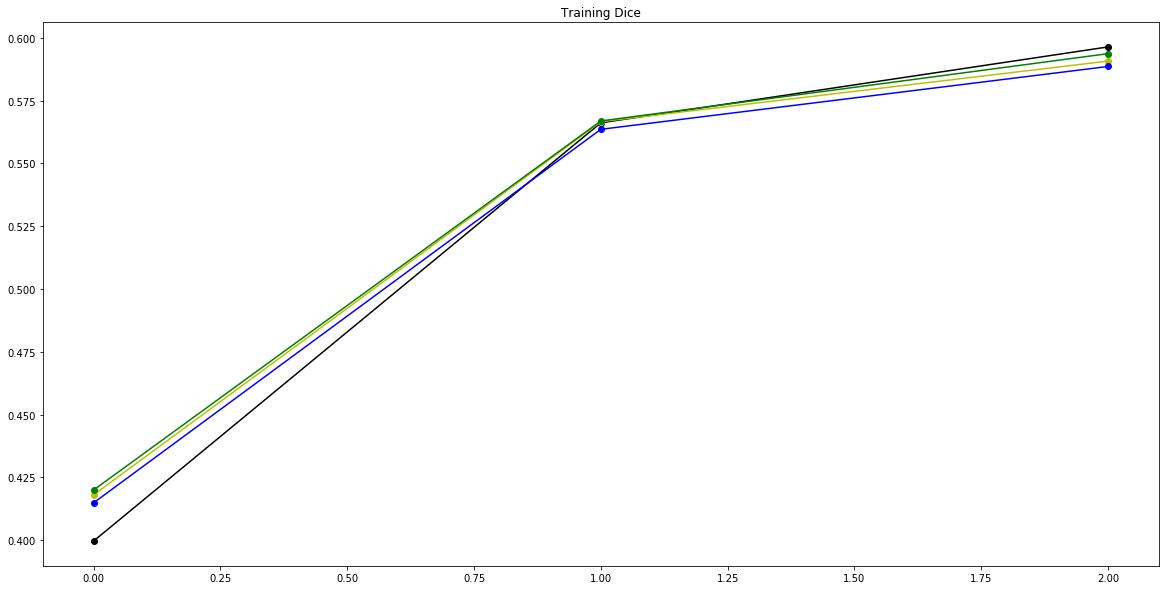

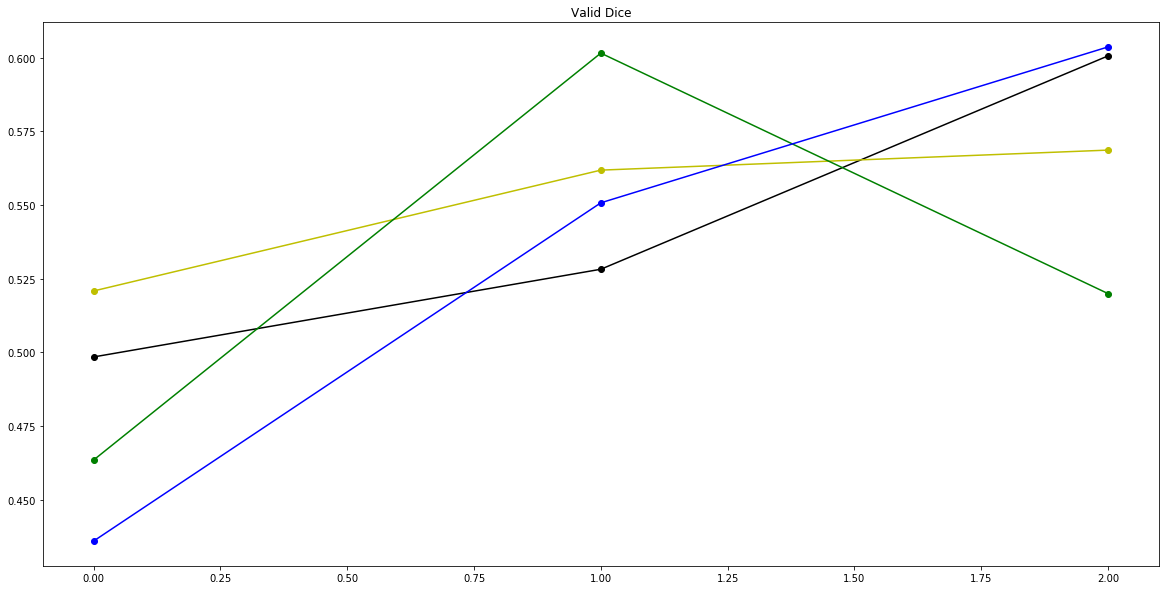

In [36]:
# Historical valus for 64 X 400
# def plot_training_dice(history15, history16, history17, history18):


    dice_coeff15 = history15.history['dice_coeff']
    val_dice_coeff15 = history15.history['val_dice_coeff']

    dice_coeff16 = history16.history['dice_coeff']
    val_dice_coeff16 = history16.history['val_dice_coeff']

    dice_coeff17 = history17.history['dice_coeff']
    val_dice_coeff17 = history17.history['val_dice_coeff']

    dice_coeff18 = history18.history['dice_coeff']
    val_dice_coeff18 = history18.history['val_dice_coeff']

    epochs = range(len(dice_coeff15))

    plt.figure(figsize=(20,10))
    plt.plot(epochs, dice_coeff15, 'k-o')
    plt.plot(epochs, dice_coeff16, 'y-o')
    plt.plot(epochs, dice_coeff17, 'g-o')
    plt.plot(epochs, dice_coeff18, 'b-o')
    plt.title('Training Dice')
    
    plt.figure(figsize=(20,10))
    plt.plot(epochs, val_dice_coeff15, 'k-o')
    plt.plot(epochs, val_dice_coeff16, 'y-o')
    plt.plot(epochs, val_dice_coeff17, 'g-o')
    plt.plot(epochs, val_dice_coeff18, 'b-o')
    plt.title('Valid Dice')
    
    plt.show()
    
    
plot_training_dice(history3_15, history3_16, history3_17, history3_18)

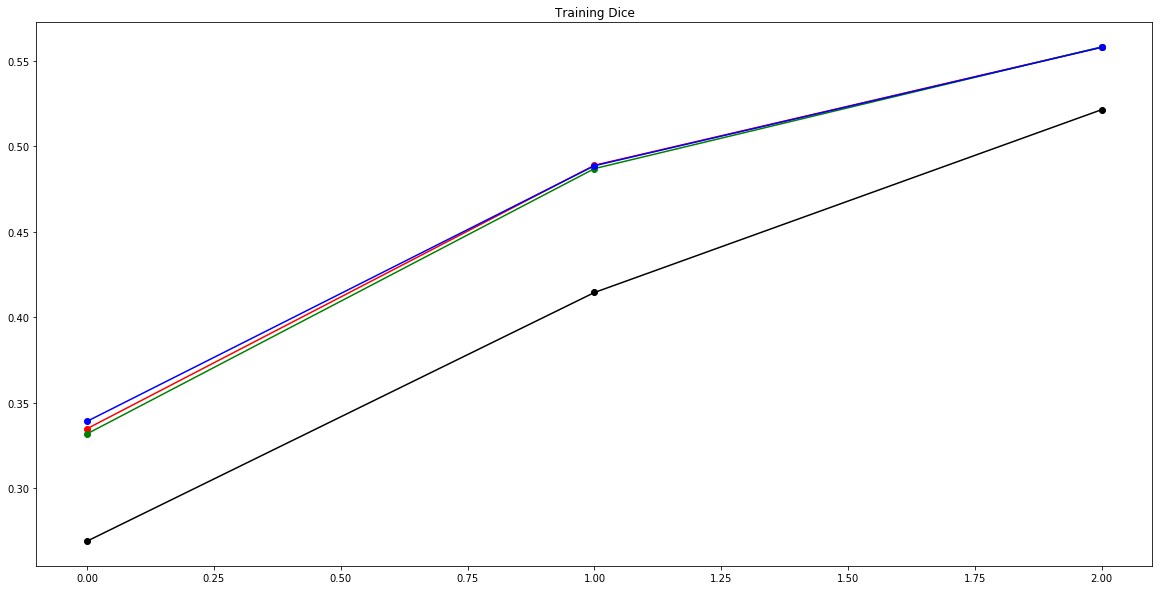

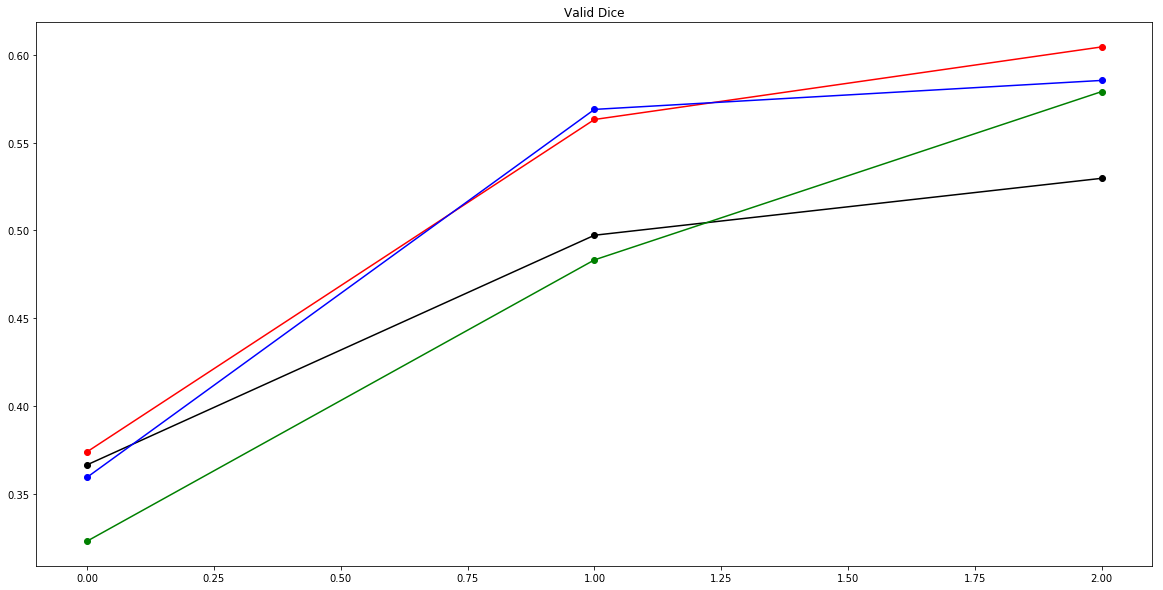

In [49]:
def plot_training_dice(history7, history13, history17, history19):

    dice_coeff7 = history7.history['dice_coeff']
    val_dice_coeff7 = history7.history['val_dice_coeff']

    dice_coeff13 = history13.history['dice_coeff']
    val_dice_coeff13 = history13.history['val_dice_coeff']

    dice_coeff17 = history17.history['dice_coeff']
    val_dice_coeff17 = history17.history['val_dice_coeff']

    dice_coeff19 = history19.history['dice_coeff']
    val_dice_coeff19 = history19.history['val_dice_coeff']

    epochs = range(len(dice_coeff7))

    plt.figure(figsize=(20,10))
    plt.plot(epochs, dice_coeff7, 'k-o')
    plt.plot(epochs, dice_coeff13, 'r-o')
    plt.plot(epochs, dice_coeff17, 'g-o')
    plt.plot(epochs, dice_coeff19, 'b-o')
    plt.title('Training Dice')
    
    plt.figure(figsize=(20,10))
    plt.plot(epochs, val_dice_coeff7, 'k-o')
    plt.plot(epochs, val_dice_coeff13, 'r-o')
    plt.plot(epochs, val_dice_coeff17, 'g-o')
    plt.plot(epochs, val_dice_coeff19, 'b-o')
    plt.title('Valid Dice')
    
    plt.show()
    
    
plot_training_dice(history3_7, history3_13, history3_17, history3_19)#

### Train on best selection for unsharp mask

In [54]:
idx = int(0.8*len(df_train))

dataGen_train = ImgDataGenerator_V1(df_train.iloc[:idx], './input/severstal-steel-defect-detection/train_images/', 
                                    outcome_img_shape=(128, 800), batch_size = 6, n_channels=3, 
                                    img_normalize=False, img_center=False, img_standardize=False,
                                    use_unsharp_mask=True, unsharp_radius=4, unsharp_amount=1.5, shuffle=False)

dataGen_valid = ImgDataGenerator_V1(df_train.iloc[idx:], './input/severstal-steel-defect-detection/train_images/', 
                                    outcome_img_shape=(128, 800), batch_size = 6, n_channels=3, 
                                    img_normalize=False, img_center=False, img_standardize=False,
                                    use_unsharp_mask=True, unsharp_radius=4, unsharp_amount=1.5, shuffle=False)

history_best_unsharp = advanced_model.fit_generator(dataGen_train,
                              epochs=EPOCHS,    
                              validation_data=dataGen_valid,
                              verbose=1,
                              shuffle=True,
                              callbacks = get_callback(PATIENCE)
                             )

Epoch 1/3


132/946 [===>..........................] - ETA: 5:27:59 - loss: 0.1700 - dice_coeff: 0.0423 - acc: 0.785 - ETA: 2:46:44 - loss: -0.0302 - dice_coeff: 0.1360 - acc: 0.82 - ETA: 1:53:02 - loss: 0.0282 - dice_coeff: 0.1055 - acc: 0.8279 - ETA: 1:26:15 - loss: 0.0107 - dice_coeff: 0.1101 - acc: 0.850 - ETA: 1:10:08 - loss: -0.0249 - dice_coeff: 0.1264 - acc: 0.84 - ETA: 59:25 - loss: -0.0392 - dice_coeff: 0.1347 - acc: 0.8477 - ETA: 51:44 - loss: -0.0422 - dice_coeff: 0.1361 - acc: 0.84 - ETA: 46:00 - loss: -0.0300 - dice_coeff: 0.1286 - acc: 0.84 - ETA: 41:30 - loss: -0.0622 - dice_coeff: 0.1437 - acc: 0.84 - ETA: 37:55 - loss: -0.0812 - dice_coeff: 0.1513 - acc: 0.84 - ETA: 34:59 - loss: -0.0752 - dice_coeff: 0.1477 - acc: 0.84 - ETA: 32:31 - loss: -0.0667 - dice_coeff: 0.1429 - acc: 0.85 - ETA: 30:27 - loss: -0.0833 - dice_coeff: 0.1498 - acc: 0.85 - ETA: 28:41 - loss: -0.1136 - dice_coeff: 0.1621 - acc: 0.86 - ETA: 27:09 - loss: -0.1290 - dice_coeff: 0.1693 - acc: 0.86 - ETA: 25:49 - l

396/946 [===========>..................] - ETA: 12:32 - loss: -0.5264 - dice_coeff: 0.3293 - acc: 0.92 - ETA: 12:31 - loss: -0.5275 - dice_coeff: 0.3299 - acc: 0.92 - ETA: 12:30 - loss: -0.5281 - dice_coeff: 0.3301 - acc: 0.92 - ETA: 12:29 - loss: -0.5285 - dice_coeff: 0.3302 - acc: 0.92 - ETA: 12:27 - loss: -0.5285 - dice_coeff: 0.3301 - acc: 0.92 - ETA: 12:27 - loss: -0.5301 - dice_coeff: 0.3309 - acc: 0.92 - ETA: 12:26 - loss: -0.5308 - dice_coeff: 0.3312 - acc: 0.92 - ETA: 12:25 - loss: -0.5303 - dice_coeff: 0.3309 - acc: 0.92 - ETA: 12:24 - loss: -0.5311 - dice_coeff: 0.3313 - acc: 0.92 - ETA: 12:22 - loss: -0.5310 - dice_coeff: 0.3312 - acc: 0.92 - ETA: 12:21 - loss: -0.5298 - dice_coeff: 0.3305 - acc: 0.92 - ETA: 12:20 - loss: -0.5308 - dice_coeff: 0.3309 - acc: 0.92 - ETA: 12:19 - loss: -0.5320 - dice_coeff: 0.3314 - acc: 0.92 - ETA: 12:18 - loss: -0.5327 - dice_coeff: 0.3317 - acc: 0.92 - ETA: 12:17 - loss: -0.5345 - dice_coeff: 0.3325 - acc: 0.92 - ETA: 12:15 - loss: -0.5359 

528/946 [===============>..............] - ETA: 10:02 - loss: -0.6203 - dice_coeff: 0.3700 - acc: 0.92 - ETA: 10:01 - loss: -0.6204 - dice_coeff: 0.3700 - acc: 0.92 - ETA: 10:00 - loss: -0.6207 - dice_coeff: 0.3701 - acc: 0.92 - ETA: 9:59 - loss: -0.6216 - dice_coeff: 0.3705 - acc: 0.9285 - ETA: 9:58 - loss: -0.6226 - dice_coeff: 0.3710 - acc: 0.928 - ETA: 9:56 - loss: -0.6232 - dice_coeff: 0.3712 - acc: 0.928 - ETA: 9:55 - loss: -0.6241 - dice_coeff: 0.3717 - acc: 0.928 - ETA: 9:54 - loss: -0.6253 - dice_coeff: 0.3722 - acc: 0.928 - ETA: 9:53 - loss: -0.6265 - dice_coeff: 0.3727 - acc: 0.928 - ETA: 9:52 - loss: -0.6266 - dice_coeff: 0.3728 - acc: 0.928 - ETA: 9:51 - loss: -0.6264 - dice_coeff: 0.3727 - acc: 0.928 - ETA: 9:50 - loss: -0.6263 - dice_coeff: 0.3726 - acc: 0.928 - ETA: 9:49 - loss: -0.6274 - dice_coeff: 0.3731 - acc: 0.928 - ETA: 9:47 - loss: -0.6277 - dice_coeff: 0.3732 - acc: 0.928 - ETA: 9:46 - loss: -0.6278 - dice_coeff: 0.3733 - acc: 0.929 - ETA: 9:45 - loss: -0.6285 

660/946 [===================>..........] - ETA: 7:36 - loss: -0.6944 - dice_coeff: 0.4032 - acc: 0.933 - ETA: 7:35 - loss: -0.6944 - dice_coeff: 0.4032 - acc: 0.933 - ETA: 7:33 - loss: -0.6952 - dice_coeff: 0.4036 - acc: 0.933 - ETA: 7:32 - loss: -0.6960 - dice_coeff: 0.4039 - acc: 0.933 - ETA: 7:31 - loss: -0.6964 - dice_coeff: 0.4041 - acc: 0.933 - ETA: 7:30 - loss: -0.6968 - dice_coeff: 0.4043 - acc: 0.933 - ETA: 7:29 - loss: -0.6976 - dice_coeff: 0.4046 - acc: 0.933 - ETA: 7:28 - loss: -0.6981 - dice_coeff: 0.4048 - acc: 0.933 - ETA: 7:27 - loss: -0.6989 - dice_coeff: 0.4052 - acc: 0.933 - ETA: 7:26 - loss: -0.6996 - dice_coeff: 0.4054 - acc: 0.933 - ETA: 7:25 - loss: -0.7002 - dice_coeff: 0.4058 - acc: 0.934 - ETA: 7:23 - loss: -0.7013 - dice_coeff: 0.4062 - acc: 0.934 - ETA: 7:22 - loss: -0.7016 - dice_coeff: 0.4063 - acc: 0.934 - ETA: 7:21 - loss: -0.7026 - dice_coeff: 0.4068 - acc: 0.934 - ETA: 7:20 - loss: -0.7035 - dice_coeff: 0.4072 - acc: 0.934 - ETA: 7:19 - loss: -0.7042 -

792/946 [========================>.....] - ETA: 5:11 - loss: -0.7533 - dice_coeff: 0.4305 - acc: 0.937 - ETA: 5:10 - loss: -0.7528 - dice_coeff: 0.4302 - acc: 0.937 - ETA: 5:08 - loss: -0.7535 - dice_coeff: 0.4305 - acc: 0.937 - ETA: 5:07 - loss: -0.7540 - dice_coeff: 0.4308 - acc: 0.937 - ETA: 5:06 - loss: -0.7543 - dice_coeff: 0.4309 - acc: 0.937 - ETA: 5:05 - loss: -0.7550 - dice_coeff: 0.4312 - acc: 0.937 - ETA: 5:04 - loss: -0.7551 - dice_coeff: 0.4313 - acc: 0.937 - ETA: 5:03 - loss: -0.7548 - dice_coeff: 0.4311 - acc: 0.937 - ETA: 5:02 - loss: -0.7549 - dice_coeff: 0.4312 - acc: 0.937 - ETA: 5:01 - loss: -0.7555 - dice_coeff: 0.4315 - acc: 0.937 - ETA: 5:00 - loss: -0.7563 - dice_coeff: 0.4319 - acc: 0.937 - ETA: 4:59 - loss: -0.7563 - dice_coeff: 0.4319 - acc: 0.937 - ETA: 4:57 - loss: -0.7569 - dice_coeff: 0.4322 - acc: 0.937 - ETA: 4:56 - loss: -0.7578 - dice_coeff: 0.4326 - acc: 0.937 - ETA: 4:55 - loss: -0.7583 - dice_coeff: 0.4329 - acc: 0.937 - ETA: 4:54 - loss: -0.7587 -

925/946 [============================>.] - ETA: 2:46 - loss: -0.7946 - dice_coeff: 0.4504 - acc: 0.938 - ETA: 2:45 - loss: -0.7946 - dice_coeff: 0.4504 - acc: 0.938 - ETA: 2:44 - loss: -0.7954 - dice_coeff: 0.4507 - acc: 0.938 - ETA: 2:43 - loss: -0.7956 - dice_coeff: 0.4509 - acc: 0.938 - ETA: 2:42 - loss: -0.7951 - dice_coeff: 0.4506 - acc: 0.938 - ETA: 2:41 - loss: -0.7947 - dice_coeff: 0.4504 - acc: 0.938 - ETA: 2:40 - loss: -0.7950 - dice_coeff: 0.4505 - acc: 0.938 - ETA: 2:39 - loss: -0.7952 - dice_coeff: 0.4506 - acc: 0.939 - ETA: 2:37 - loss: -0.7954 - dice_coeff: 0.4507 - acc: 0.939 - ETA: 2:36 - loss: -0.7957 - dice_coeff: 0.4509 - acc: 0.939 - ETA: 2:35 - loss: -0.7957 - dice_coeff: 0.4508 - acc: 0.939 - ETA: 2:34 - loss: -0.7961 - dice_coeff: 0.4511 - acc: 0.939 - ETA: 2:33 - loss: -0.7963 - dice_coeff: 0.4512 - acc: 0.939 - ETA: 2:32 - loss: -0.7967 - dice_coeff: 0.4514 - acc: 0.939 - ETA: 2:31 - loss: -0.7966 - dice_coeff: 0.4513 - acc: 0.939 - ETA: 2:30 - loss: -0.7970 -

946/946 [==============================] - ETA: 21s - loss: -0.8298 - dice_coeff: 0.4671 - acc: 0.94 - ETA: 20s - loss: -0.8298 - dice_coeff: 0.4670 - acc: 0.94 - ETA: 19s - loss: -0.8298 - dice_coeff: 0.4671 - acc: 0.94 - ETA: 18s - loss: -0.8299 - dice_coeff: 0.4672 - acc: 0.94 - ETA: 17s - loss: -0.8303 - dice_coeff: 0.4673 - acc: 0.94 - ETA: 16s - loss: -0.8304 - dice_coeff: 0.4674 - acc: 0.94 - ETA: 15s - loss: -0.8303 - dice_coeff: 0.4673 - acc: 0.94 - ETA: 14s - loss: -0.8307 - dice_coeff: 0.4675 - acc: 0.94 - ETA: 13s - loss: -0.8303 - dice_coeff: 0.4673 - acc: 0.94 - ETA: 11s - loss: -0.8302 - dice_coeff: 0.4673 - acc: 0.94 - ETA: 10s - loss: -0.8302 - dice_coeff: 0.4673 - acc: 0.94 - ETA: 9s - loss: -0.8307 - dice_coeff: 0.4675 - acc: 0.9409 - ETA: 8s - loss: -0.8308 - dice_coeff: 0.4675 - acc: 0.941 - ETA: 7s - loss: -0.8309 - dice_coeff: 0.4676 - acc: 0.941 - ETA: 6s - loss: -0.8317 - dice_coeff: 0.4679 - acc: 0.941 - ETA: 5s - loss: -0.8322 - dice_coeff: 0.4682 - acc: 0.94

132/946 [===>..........................] - ETA: 6:09 - loss: -1.1606 - dice_coeff: 0.6182 - acc: 0.958 - ETA: 6:05 - loss: -1.0292 - dice_coeff: 0.5877 - acc: 0.938 - ETA: 6:03 - loss: -0.9860 - dice_coeff: 0.5546 - acc: 0.945 - ETA: 6:02 - loss: -0.9076 - dice_coeff: 0.5148 - acc: 0.938 - ETA: 6:01 - loss: -0.8534 - dice_coeff: 0.4983 - acc: 0.930 - ETA: 6:01 - loss: -0.9274 - dice_coeff: 0.5281 - acc: 0.937 - ETA: 6:00 - loss: -0.9350 - dice_coeff: 0.5270 - acc: 0.941 - ETA: 6:00 - loss: -0.9107 - dice_coeff: 0.5133 - acc: 0.942 - ETA: 6:00 - loss: -0.9279 - dice_coeff: 0.5214 - acc: 0.943 - ETA: 6:00 - loss: -0.9092 - dice_coeff: 0.5101 - acc: 0.944 - ETA: 5:59 - loss: -0.8768 - dice_coeff: 0.4944 - acc: 0.944 - ETA: 5:59 - loss: -0.8794 - dice_coeff: 0.4944 - acc: 0.945 - ETA: 6:00 - loss: -0.9172 - dice_coeff: 0.5110 - acc: 0.947 - ETA: 6:00 - loss: -0.9511 - dice_coeff: 0.5258 - acc: 0.949 - ETA: 5:59 - loss: -0.9774 - dice_coeff: 0.5385 - acc: 0.950 - ETA: 5:59 - loss: -0.9810 -

396/946 [===========>..................] - ETA: 12:24 - loss: -1.0342 - dice_coeff: 0.5652 - acc: 0.95 - ETA: 12:23 - loss: -1.0323 - dice_coeff: 0.5649 - acc: 0.95 - ETA: 12:22 - loss: -1.0312 - dice_coeff: 0.5643 - acc: 0.95 - ETA: 12:22 - loss: -1.0314 - dice_coeff: 0.5644 - acc: 0.95 - ETA: 12:21 - loss: -1.0324 - dice_coeff: 0.5647 - acc: 0.95 - ETA: 12:20 - loss: -1.0294 - dice_coeff: 0.5636 - acc: 0.95 - ETA: 12:19 - loss: -1.0295 - dice_coeff: 0.5637 - acc: 0.95 - ETA: 12:18 - loss: -1.0297 - dice_coeff: 0.5637 - acc: 0.95 - ETA: 12:17 - loss: -1.0304 - dice_coeff: 0.5640 - acc: 0.95 - ETA: 12:17 - loss: -1.0319 - dice_coeff: 0.5647 - acc: 0.95 - ETA: 12:16 - loss: -1.0333 - dice_coeff: 0.5653 - acc: 0.95 - ETA: 12:15 - loss: -1.0342 - dice_coeff: 0.5658 - acc: 0.95 - ETA: 12:14 - loss: -1.0350 - dice_coeff: 0.5661 - acc: 0.95 - ETA: 12:13 - loss: -1.0341 - dice_coeff: 0.5657 - acc: 0.95 - ETA: 12:12 - loss: -1.0346 - dice_coeff: 0.5658 - acc: 0.95 - ETA: 12:11 - loss: -1.0354 

528/946 [===============>..............] - ETA: 10:07 - loss: -1.0624 - dice_coeff: 0.5778 - acc: 0.95 - ETA: 10:06 - loss: -1.0634 - dice_coeff: 0.5783 - acc: 0.95 - ETA: 10:05 - loss: -1.0631 - dice_coeff: 0.5782 - acc: 0.95 - ETA: 10:04 - loss: -1.0634 - dice_coeff: 0.5783 - acc: 0.95 - ETA: 10:02 - loss: -1.0625 - dice_coeff: 0.5778 - acc: 0.95 - ETA: 10:01 - loss: -1.0629 - dice_coeff: 0.5780 - acc: 0.95 - ETA: 10:00 - loss: -1.0630 - dice_coeff: 0.5780 - acc: 0.95 - ETA: 9:59 - loss: -1.0620 - dice_coeff: 0.5776 - acc: 0.9539 - ETA: 9:58 - loss: -1.0619 - dice_coeff: 0.5775 - acc: 0.954 - ETA: 9:57 - loss: -1.0626 - dice_coeff: 0.5777 - acc: 0.954 - ETA: 9:56 - loss: -1.0625 - dice_coeff: 0.5778 - acc: 0.954 - ETA: 9:54 - loss: -1.0626 - dice_coeff: 0.5778 - acc: 0.954 - ETA: 9:53 - loss: -1.0623 - dice_coeff: 0.5777 - acc: 0.954 - ETA: 9:52 - loss: -1.0633 - dice_coeff: 0.5782 - acc: 0.954 - ETA: 9:51 - loss: -1.0633 - dice_coeff: 0.5782 - acc: 0.954 - ETA: 9:50 - loss: -1.0629 

660/946 [===================>..........] - ETA: 7:38 - loss: -1.0718 - dice_coeff: 0.5819 - acc: 0.954 - ETA: 7:37 - loss: -1.0714 - dice_coeff: 0.5818 - acc: 0.954 - ETA: 7:36 - loss: -1.0716 - dice_coeff: 0.5818 - acc: 0.954 - ETA: 7:35 - loss: -1.0713 - dice_coeff: 0.5817 - acc: 0.954 - ETA: 7:34 - loss: -1.0709 - dice_coeff: 0.5815 - acc: 0.954 - ETA: 7:33 - loss: -1.0709 - dice_coeff: 0.5816 - acc: 0.954 - ETA: 7:32 - loss: -1.0703 - dice_coeff: 0.5813 - acc: 0.954 - ETA: 7:30 - loss: -1.0701 - dice_coeff: 0.5811 - acc: 0.954 - ETA: 7:29 - loss: -1.0705 - dice_coeff: 0.5813 - acc: 0.954 - ETA: 7:28 - loss: -1.0708 - dice_coeff: 0.5814 - acc: 0.954 - ETA: 7:27 - loss: -1.0698 - dice_coeff: 0.5809 - acc: 0.954 - ETA: 7:26 - loss: -1.0699 - dice_coeff: 0.5810 - acc: 0.954 - ETA: 7:25 - loss: -1.0694 - dice_coeff: 0.5807 - acc: 0.954 - ETA: 7:24 - loss: -1.0697 - dice_coeff: 0.5808 - acc: 0.954 - ETA: 7:23 - loss: -1.0699 - dice_coeff: 0.5809 - acc: 0.954 - ETA: 7:22 - loss: -1.0706 -

792/946 [========================>.....] - ETA: 5:12 - loss: -1.0645 - dice_coeff: 0.5788 - acc: 0.954 - ETA: 5:11 - loss: -1.0648 - dice_coeff: 0.5789 - acc: 0.954 - ETA: 5:10 - loss: -1.0653 - dice_coeff: 0.5791 - acc: 0.954 - ETA: 5:09 - loss: -1.0657 - dice_coeff: 0.5793 - acc: 0.954 - ETA: 5:08 - loss: -1.0662 - dice_coeff: 0.5795 - acc: 0.954 - ETA: 5:06 - loss: -1.0660 - dice_coeff: 0.5794 - acc: 0.954 - ETA: 5:05 - loss: -1.0666 - dice_coeff: 0.5797 - acc: 0.954 - ETA: 5:04 - loss: -1.0667 - dice_coeff: 0.5797 - acc: 0.954 - ETA: 5:03 - loss: -1.0669 - dice_coeff: 0.5798 - acc: 0.954 - ETA: 5:02 - loss: -1.0675 - dice_coeff: 0.5801 - acc: 0.954 - ETA: 5:01 - loss: -1.0672 - dice_coeff: 0.5800 - acc: 0.954 - ETA: 5:00 - loss: -1.0674 - dice_coeff: 0.5801 - acc: 0.954 - ETA: 4:59 - loss: -1.0675 - dice_coeff: 0.5801 - acc: 0.954 - ETA: 4:58 - loss: -1.0677 - dice_coeff: 0.5802 - acc: 0.954 - ETA: 4:56 - loss: -1.0677 - dice_coeff: 0.5802 - acc: 0.954 - ETA: 4:55 - loss: -1.0681 -

925/946 [============================>.] - ETA: 2:47 - loss: -1.0707 - dice_coeff: 0.5817 - acc: 0.954 - ETA: 2:46 - loss: -1.0710 - dice_coeff: 0.5819 - acc: 0.954 - ETA: 2:45 - loss: -1.0707 - dice_coeff: 0.5817 - acc: 0.954 - ETA: 2:43 - loss: -1.0703 - dice_coeff: 0.5816 - acc: 0.954 - ETA: 2:42 - loss: -1.0709 - dice_coeff: 0.5818 - acc: 0.954 - ETA: 2:41 - loss: -1.0711 - dice_coeff: 0.5819 - acc: 0.954 - ETA: 2:40 - loss: -1.0712 - dice_coeff: 0.5820 - acc: 0.954 - ETA: 2:39 - loss: -1.0714 - dice_coeff: 0.5820 - acc: 0.955 - ETA: 2:38 - loss: -1.0716 - dice_coeff: 0.5821 - acc: 0.955 - ETA: 2:37 - loss: -1.0718 - dice_coeff: 0.5822 - acc: 0.955 - ETA: 2:36 - loss: -1.0718 - dice_coeff: 0.5822 - acc: 0.955 - ETA: 2:35 - loss: -1.0722 - dice_coeff: 0.5824 - acc: 0.955 - ETA: 2:34 - loss: -1.0725 - dice_coeff: 0.5825 - acc: 0.955 - ETA: 2:32 - loss: -1.0731 - dice_coeff: 0.5828 - acc: 0.955 - ETA: 2:31 - loss: -1.0731 - dice_coeff: 0.5829 - acc: 0.954 - ETA: 2:30 - loss: -1.0725 -

946/946 [==============================] - ETA: 21s - loss: -1.0835 - dice_coeff: 0.5879 - acc: 0.95 - ETA: 20s - loss: -1.0834 - dice_coeff: 0.5879 - acc: 0.95 - ETA: 19s - loss: -1.0832 - dice_coeff: 0.5879 - acc: 0.95 - ETA: 18s - loss: -1.0831 - dice_coeff: 0.5878 - acc: 0.95 - ETA: 17s - loss: -1.0829 - dice_coeff: 0.5877 - acc: 0.95 - ETA: 16s - loss: -1.0827 - dice_coeff: 0.5876 - acc: 0.95 - ETA: 15s - loss: -1.0824 - dice_coeff: 0.5875 - acc: 0.95 - ETA: 14s - loss: -1.0825 - dice_coeff: 0.5875 - acc: 0.95 - ETA: 13s - loss: -1.0828 - dice_coeff: 0.5876 - acc: 0.95 - ETA: 11s - loss: -1.0827 - dice_coeff: 0.5877 - acc: 0.95 - ETA: 10s - loss: -1.0828 - dice_coeff: 0.5877 - acc: 0.95 - ETA: 9s - loss: -1.0828 - dice_coeff: 0.5877 - acc: 0.9549 - ETA: 8s - loss: -1.0833 - dice_coeff: 0.5879 - acc: 0.954 - ETA: 7s - loss: -1.0835 - dice_coeff: 0.5881 - acc: 0.955 - ETA: 6s - loss: -1.0835 - dice_coeff: 0.5880 - acc: 0.955 - ETA: 5s - loss: -1.0835 - dice_coeff: 0.5880 - acc: 0.95

132/946 [===>..........................] - ETA: 6:05 - loss: -1.0118 - dice_coeff: 0.5651 - acc: 0.948 - ETA: 6:10 - loss: -1.2066 - dice_coeff: 0.6460 - acc: 0.962 - ETA: 6:07 - loss: -1.1198 - dice_coeff: 0.6122 - acc: 0.955 - ETA: 6:09 - loss: -0.9724 - dice_coeff: 0.5630 - acc: 0.939 - ETA: 6:10 - loss: -1.0407 - dice_coeff: 0.5876 - acc: 0.944 - ETA: 6:08 - loss: -1.0973 - dice_coeff: 0.6128 - acc: 0.945 - ETA: 6:07 - loss: -1.0815 - dice_coeff: 0.6019 - acc: 0.945 - ETA: 6:07 - loss: -1.0771 - dice_coeff: 0.6086 - acc: 0.939 - ETA: 6:06 - loss: -1.0831 - dice_coeff: 0.6071 - acc: 0.941 - ETA: 6:05 - loss: -1.0205 - dice_coeff: 0.5770 - acc: 0.938 - ETA: 6:04 - loss: -1.0391 - dice_coeff: 0.5835 - acc: 0.940 - ETA: 6:04 - loss: -1.0680 - dice_coeff: 0.5941 - acc: 0.944 - ETA: 6:03 - loss: -1.0753 - dice_coeff: 0.5973 - acc: 0.943 - ETA: 6:02 - loss: -1.0659 - dice_coeff: 0.5907 - acc: 0.945 - ETA: 6:30 - loss: -1.0708 - dice_coeff: 0.5908 - acc: 0.947 - ETA: 7:28 - loss: -1.0554 -

396/946 [===========>..................] - ETA: 11:55 - loss: -1.1221 - dice_coeff: 0.6066 - acc: 0.95 - ETA: 11:54 - loss: -1.1219 - dice_coeff: 0.6065 - acc: 0.95 - ETA: 11:53 - loss: -1.1227 - dice_coeff: 0.6069 - acc: 0.95 - ETA: 11:52 - loss: -1.1235 - dice_coeff: 0.6073 - acc: 0.95 - ETA: 11:51 - loss: -1.1247 - dice_coeff: 0.6078 - acc: 0.95 - ETA: 11:50 - loss: -1.1255 - dice_coeff: 0.6081 - acc: 0.95 - ETA: 11:49 - loss: -1.1261 - dice_coeff: 0.6083 - acc: 0.95 - ETA: 11:48 - loss: -1.1252 - dice_coeff: 0.6079 - acc: 0.95 - ETA: 11:47 - loss: -1.1260 - dice_coeff: 0.6083 - acc: 0.95 - ETA: 11:46 - loss: -1.1251 - dice_coeff: 0.6078 - acc: 0.95 - ETA: 11:45 - loss: -1.1257 - dice_coeff: 0.6080 - acc: 0.95 - ETA: 11:44 - loss: -1.1260 - dice_coeff: 0.6081 - acc: 0.95 - ETA: 11:43 - loss: -1.1276 - dice_coeff: 0.6088 - acc: 0.95 - ETA: 11:42 - loss: -1.1282 - dice_coeff: 0.6091 - acc: 0.95 - ETA: 11:41 - loss: -1.1290 - dice_coeff: 0.6095 - acc: 0.95 - ETA: 11:40 - loss: -1.1284 

528/946 [===============>..............] - ETA: 9:41 - loss: -1.1214 - dice_coeff: 0.6052 - acc: 0.958 - ETA: 9:40 - loss: -1.1226 - dice_coeff: 0.6057 - acc: 0.958 - ETA: 9:39 - loss: -1.1228 - dice_coeff: 0.6058 - acc: 0.958 - ETA: 9:38 - loss: -1.1233 - dice_coeff: 0.6060 - acc: 0.958 - ETA: 9:37 - loss: -1.1227 - dice_coeff: 0.6058 - acc: 0.958 - ETA: 9:36 - loss: -1.1232 - dice_coeff: 0.6060 - acc: 0.958 - ETA: 9:35 - loss: -1.1236 - dice_coeff: 0.6062 - acc: 0.958 - ETA: 9:34 - loss: -1.1239 - dice_coeff: 0.6063 - acc: 0.958 - ETA: 9:32 - loss: -1.1235 - dice_coeff: 0.6061 - acc: 0.958 - ETA: 9:31 - loss: -1.1236 - dice_coeff: 0.6061 - acc: 0.958 - ETA: 9:30 - loss: -1.1237 - dice_coeff: 0.6062 - acc: 0.958 - ETA: 9:29 - loss: -1.1240 - dice_coeff: 0.6064 - acc: 0.958 - ETA: 9:28 - loss: -1.1237 - dice_coeff: 0.6063 - acc: 0.958 - ETA: 9:27 - loss: -1.1243 - dice_coeff: 0.6065 - acc: 0.958 - ETA: 9:26 - loss: -1.1252 - dice_coeff: 0.6069 - acc: 0.958 - ETA: 9:25 - loss: -1.1246 -

660/946 [===================>..........] - ETA: 7:23 - loss: -1.1271 - dice_coeff: 0.6077 - acc: 0.958 - ETA: 7:22 - loss: -1.1268 - dice_coeff: 0.6076 - acc: 0.958 - ETA: 7:21 - loss: -1.1274 - dice_coeff: 0.6078 - acc: 0.958 - ETA: 7:20 - loss: -1.1272 - dice_coeff: 0.6077 - acc: 0.958 - ETA: 7:19 - loss: -1.1281 - dice_coeff: 0.6081 - acc: 0.958 - ETA: 7:18 - loss: -1.1286 - dice_coeff: 0.6083 - acc: 0.958 - ETA: 7:17 - loss: -1.1289 - dice_coeff: 0.6084 - acc: 0.958 - ETA: 7:16 - loss: -1.1291 - dice_coeff: 0.6086 - acc: 0.958 - ETA: 7:15 - loss: -1.1290 - dice_coeff: 0.6084 - acc: 0.958 - ETA: 7:14 - loss: -1.1286 - dice_coeff: 0.6083 - acc: 0.958 - ETA: 7:13 - loss: -1.1291 - dice_coeff: 0.6085 - acc: 0.958 - ETA: 7:12 - loss: -1.1298 - dice_coeff: 0.6088 - acc: 0.958 - ETA: 7:11 - loss: -1.1298 - dice_coeff: 0.6088 - acc: 0.958 - ETA: 7:10 - loss: -1.1300 - dice_coeff: 0.6089 - acc: 0.958 - ETA: 7:09 - loss: -1.1304 - dice_coeff: 0.6090 - acc: 0.958 - ETA: 7:08 - loss: -1.1303 -

792/946 [========================>.....] - ETA: 5:04 - loss: -1.1327 - dice_coeff: 0.6103 - acc: 0.958 - ETA: 5:02 - loss: -1.1323 - dice_coeff: 0.6101 - acc: 0.958 - ETA: 5:01 - loss: -1.1326 - dice_coeff: 0.6102 - acc: 0.958 - ETA: 5:00 - loss: -1.1316 - dice_coeff: 0.6098 - acc: 0.958 - ETA: 4:59 - loss: -1.1319 - dice_coeff: 0.6099 - acc: 0.958 - ETA: 4:58 - loss: -1.1321 - dice_coeff: 0.6100 - acc: 0.958 - ETA: 4:57 - loss: -1.1317 - dice_coeff: 0.6098 - acc: 0.958 - ETA: 4:56 - loss: -1.1316 - dice_coeff: 0.6097 - acc: 0.958 - ETA: 4:55 - loss: -1.1321 - dice_coeff: 0.6099 - acc: 0.958 - ETA: 4:54 - loss: -1.1322 - dice_coeff: 0.6100 - acc: 0.958 - ETA: 4:53 - loss: -1.1314 - dice_coeff: 0.6096 - acc: 0.958 - ETA: 4:52 - loss: -1.1316 - dice_coeff: 0.6097 - acc: 0.958 - ETA: 4:51 - loss: -1.1314 - dice_coeff: 0.6097 - acc: 0.958 - ETA: 4:50 - loss: -1.1308 - dice_coeff: 0.6094 - acc: 0.958 - ETA: 4:49 - loss: -1.1314 - dice_coeff: 0.6097 - acc: 0.958 - ETA: 4:48 - loss: -1.1317 -

925/946 [============================>.] - ETA: 2:43 - loss: -1.1340 - dice_coeff: 0.6110 - acc: 0.958 - ETA: 2:42 - loss: -1.1341 - dice_coeff: 0.6111 - acc: 0.958 - ETA: 2:41 - loss: -1.1338 - dice_coeff: 0.6109 - acc: 0.958 - ETA: 2:40 - loss: -1.1337 - dice_coeff: 0.6109 - acc: 0.958 - ETA: 2:39 - loss: -1.1340 - dice_coeff: 0.6111 - acc: 0.958 - ETA: 2:38 - loss: -1.1340 - dice_coeff: 0.6111 - acc: 0.958 - ETA: 2:36 - loss: -1.1337 - dice_coeff: 0.6109 - acc: 0.958 - ETA: 2:35 - loss: -1.1334 - dice_coeff: 0.6108 - acc: 0.958 - ETA: 2:34 - loss: -1.1336 - dice_coeff: 0.6109 - acc: 0.957 - ETA: 2:33 - loss: -1.1336 - dice_coeff: 0.6109 - acc: 0.958 - ETA: 2:32 - loss: -1.1333 - dice_coeff: 0.6107 - acc: 0.958 - ETA: 2:31 - loss: -1.1330 - dice_coeff: 0.6106 - acc: 0.958 - ETA: 2:30 - loss: -1.1328 - dice_coeff: 0.6105 - acc: 0.958 - ETA: 2:29 - loss: -1.1325 - dice_coeff: 0.6103 - acc: 0.958 - ETA: 2:28 - loss: -1.1322 - dice_coeff: 0.6102 - acc: 0.957 - ETA: 2:27 - loss: -1.1325 -

946/946 [==============================] - ETA: 21s - loss: -1.1339 - dice_coeff: 0.6113 - acc: 0.95 - ETA: 20s - loss: -1.1338 - dice_coeff: 0.6113 - acc: 0.95 - ETA: 19s - loss: -1.1333 - dice_coeff: 0.6110 - acc: 0.95 - ETA: 18s - loss: -1.1336 - dice_coeff: 0.6112 - acc: 0.95 - ETA: 17s - loss: -1.1331 - dice_coeff: 0.6109 - acc: 0.95 - ETA: 16s - loss: -1.1331 - dice_coeff: 0.6109 - acc: 0.95 - ETA: 14s - loss: -1.1334 - dice_coeff: 0.6110 - acc: 0.95 - ETA: 13s - loss: -1.1331 - dice_coeff: 0.6109 - acc: 0.95 - ETA: 12s - loss: -1.1332 - dice_coeff: 0.6110 - acc: 0.95 - ETA: 11s - loss: -1.1334 - dice_coeff: 0.6111 - acc: 0.95 - ETA: 10s - loss: -1.1332 - dice_coeff: 0.6110 - acc: 0.95 - ETA: 9s - loss: -1.1331 - dice_coeff: 0.6110 - acc: 0.9573 - ETA: 8s - loss: -1.1334 - dice_coeff: 0.6111 - acc: 0.957 - ETA: 7s - loss: -1.1336 - dice_coeff: 0.6112 - acc: 0.957 - ETA: 6s - loss: -1.1339 - dice_coeff: 0.6114 - acc: 0.957 - ETA: 5s - loss: -1.1343 - dice_coeff: 0.6115 - acc: 0.95

In [20]:
def plot_training_best(history_best_unsharp):

    acc = history_best_unsharp.history['acc']
    val_acc = history_best_unsharp.history['val_acc']

    dice_coeff = history_best_unsharp.history['dice_coeff']
    val_dice_coeff = history_best_unsharp.history['val_dice_coeff']

    epochs = range(len(dice_coeff))

    plt.figure(figsize=(20,10))
    plt.plot(epochs, acc, 'k-o')
    plt.plot(epochs, val_acc, 'r-o')
    plt.title('Training Dice')
    
    plt.figure(figsize=(20,10))
    plt.plot(epochs, dice_coeff, 'k-o')
    plt.plot(epochs, val_dice_coeff, 'r-o')
    plt.title('Training Dice')

    plt.show()
    
    
#plot_training_best(history_best_unsharp)

### Augment Train Data and build on top of best selection for unsharp mask

In [60]:
idx = int(0.2*len(df_train))

dataGen_train_aug_rep2 = ImgDataGenerator_V1(df_train.iloc[idx:], './input/severstal-steel-defect-detection/train_images/', 
                                    outcome_img_shape=(128, 800), batch_size = 6, n_channels=3, 
                                    img_normalize=False, img_center=False, img_standardize=False,
                                    use_unsharp_mask=True, unsharp_radius=4, unsharp_amount=1.5, 
                                    shuffle=False)

dataGen_valid_no_aug_rep2 = ImgDataGenerator_V1(df_train.iloc[:idx], './input/severstal-steel-defect-detection/train_images/', 
                                    outcome_img_shape=(128, 800), batch_size = 6, n_channels=3, 
                                    img_normalize=False, img_center=False, img_standardize=False,
                                    use_unsharp_mask=True, unsharp_radius=4, unsharp_amount=1.5, shuffle=False)

history_best_unsharp_rep2 = advanced_model.fit_generator(dataGen_train_aug_rep2,
                              epochs=3,    
                              validation_data=dataGen_valid_no_aug_rep2,
                              verbose=1,
                              shuffle=True,
                              callbacks = get_callback(1)
                             )

Epoch 1/3


132/946 [===>..........................] - ETA: 27:15 - loss: -1.3705 - dice_coeff: 0.7120 - acc: 0.97 - ETA: 24:26 - loss: -1.0457 - dice_coeff: 0.5792 - acc: 0.94 - ETA: 23:26 - loss: -1.1513 - dice_coeff: 0.6231 - acc: 0.95 - ETA: 23:10 - loss: -1.2252 - dice_coeff: 0.6533 - acc: 0.96 - ETA: 22:48 - loss: -1.3018 - dice_coeff: 0.6864 - acc: 0.96 - ETA: 22:32 - loss: -1.2541 - dice_coeff: 0.6677 - acc: 0.96 - ETA: 22:22 - loss: -1.1588 - dice_coeff: 0.6261 - acc: 0.95 - ETA: 22:16 - loss: -1.1374 - dice_coeff: 0.6153 - acc: 0.95 - ETA: 22:06 - loss: -1.1807 - dice_coeff: 0.6330 - acc: 0.95 - ETA: 21:58 - loss: -1.1845 - dice_coeff: 0.6374 - acc: 0.95 - ETA: 21:50 - loss: -1.1560 - dice_coeff: 0.6256 - acc: 0.95 - ETA: 21:27 - loss: -1.1300 - dice_coeff: 0.6132 - acc: 0.95 - ETA: 21:03 - loss: -1.1176 - dice_coeff: 0.6074 - acc: 0.95 - ETA: 20:46 - loss: -1.1150 - dice_coeff: 0.6048 - acc: 0.95 - ETA: 20:30 - loss: -1.0867 - dice_coeff: 0.5946 - acc: 0.95 - ETA: 20:12 - loss: -1.0890 

396/946 [===========>..................] - ETA: 12:15 - loss: -1.1619 - dice_coeff: 0.6244 - acc: 0.95 - ETA: 12:14 - loss: -1.1609 - dice_coeff: 0.6239 - acc: 0.95 - ETA: 12:12 - loss: -1.1609 - dice_coeff: 0.6239 - acc: 0.95 - ETA: 12:11 - loss: -1.1608 - dice_coeff: 0.6238 - acc: 0.95 - ETA: 12:10 - loss: -1.1592 - dice_coeff: 0.6231 - acc: 0.95 - ETA: 12:09 - loss: -1.1588 - dice_coeff: 0.6229 - acc: 0.95 - ETA: 12:08 - loss: -1.1601 - dice_coeff: 0.6235 - acc: 0.95 - ETA: 12:07 - loss: -1.1605 - dice_coeff: 0.6236 - acc: 0.95 - ETA: 12:06 - loss: -1.1600 - dice_coeff: 0.6236 - acc: 0.95 - ETA: 12:05 - loss: -1.1605 - dice_coeff: 0.6238 - acc: 0.95 - ETA: 12:03 - loss: -1.1602 - dice_coeff: 0.6236 - acc: 0.95 - ETA: 12:02 - loss: -1.1607 - dice_coeff: 0.6239 - acc: 0.95 - ETA: 12:01 - loss: -1.1616 - dice_coeff: 0.6242 - acc: 0.95 - ETA: 12:00 - loss: -1.1622 - dice_coeff: 0.6244 - acc: 0.95 - ETA: 11:59 - loss: -1.1631 - dice_coeff: 0.6248 - acc: 0.95 - ETA: 11:58 - loss: -1.1638 

528/946 [===============>..............] - ETA: 9:50 - loss: -1.1527 - dice_coeff: 0.6207 - acc: 0.957 - ETA: 9:49 - loss: -1.1527 - dice_coeff: 0.6207 - acc: 0.957 - ETA: 9:48 - loss: -1.1530 - dice_coeff: 0.6208 - acc: 0.957 - ETA: 9:47 - loss: -1.1529 - dice_coeff: 0.6207 - acc: 0.957 - ETA: 9:45 - loss: -1.1530 - dice_coeff: 0.6208 - acc: 0.957 - ETA: 9:44 - loss: -1.1528 - dice_coeff: 0.6207 - acc: 0.957 - ETA: 9:43 - loss: -1.1520 - dice_coeff: 0.6203 - acc: 0.957 - ETA: 9:42 - loss: -1.1530 - dice_coeff: 0.6208 - acc: 0.957 - ETA: 9:41 - loss: -1.1527 - dice_coeff: 0.6206 - acc: 0.957 - ETA: 9:40 - loss: -1.1516 - dice_coeff: 0.6202 - acc: 0.957 - ETA: 9:39 - loss: -1.1523 - dice_coeff: 0.6205 - acc: 0.957 - ETA: 9:38 - loss: -1.1521 - dice_coeff: 0.6205 - acc: 0.957 - ETA: 9:37 - loss: -1.1522 - dice_coeff: 0.6205 - acc: 0.957 - ETA: 9:36 - loss: -1.1528 - dice_coeff: 0.6207 - acc: 0.957 - ETA: 9:35 - loss: -1.1533 - dice_coeff: 0.6209 - acc: 0.957 - ETA: 9:34 - loss: -1.1534 -

660/946 [===================>..........] - ETA: 7:28 - loss: -1.1568 - dice_coeff: 0.6222 - acc: 0.957 - ETA: 7:26 - loss: -1.1566 - dice_coeff: 0.6220 - acc: 0.957 - ETA: 7:25 - loss: -1.1566 - dice_coeff: 0.6221 - acc: 0.957 - ETA: 7:24 - loss: -1.1567 - dice_coeff: 0.6221 - acc: 0.957 - ETA: 7:23 - loss: -1.1576 - dice_coeff: 0.6225 - acc: 0.958 - ETA: 7:22 - loss: -1.1580 - dice_coeff: 0.6226 - acc: 0.958 - ETA: 7:21 - loss: -1.1576 - dice_coeff: 0.6225 - acc: 0.958 - ETA: 7:20 - loss: -1.1576 - dice_coeff: 0.6224 - acc: 0.958 - ETA: 7:19 - loss: -1.1576 - dice_coeff: 0.6224 - acc: 0.958 - ETA: 7:18 - loss: -1.1579 - dice_coeff: 0.6226 - acc: 0.958 - ETA: 7:17 - loss: -1.1583 - dice_coeff: 0.6227 - acc: 0.958 - ETA: 7:16 - loss: -1.1586 - dice_coeff: 0.6229 - acc: 0.958 - ETA: 7:15 - loss: -1.1592 - dice_coeff: 0.6231 - acc: 0.958 - ETA: 7:13 - loss: -1.1585 - dice_coeff: 0.6228 - acc: 0.958 - ETA: 7:12 - loss: -1.1586 - dice_coeff: 0.6229 - acc: 0.958 - ETA: 7:11 - loss: -1.1586 -

792/946 [========================>.....] - ETA: 5:06 - loss: -1.1525 - dice_coeff: 0.6201 - acc: 0.958 - ETA: 5:04 - loss: -1.1514 - dice_coeff: 0.6197 - acc: 0.957 - ETA: 5:03 - loss: -1.1517 - dice_coeff: 0.6199 - acc: 0.957 - ETA: 5:02 - loss: -1.1519 - dice_coeff: 0.6199 - acc: 0.957 - ETA: 5:01 - loss: -1.1510 - dice_coeff: 0.6197 - acc: 0.957 - ETA: 5:00 - loss: -1.1508 - dice_coeff: 0.6195 - acc: 0.957 - ETA: 4:59 - loss: -1.1507 - dice_coeff: 0.6194 - acc: 0.957 - ETA: 4:58 - loss: -1.1507 - dice_coeff: 0.6194 - acc: 0.957 - ETA: 4:57 - loss: -1.1510 - dice_coeff: 0.6195 - acc: 0.957 - ETA: 4:56 - loss: -1.1515 - dice_coeff: 0.6198 - acc: 0.957 - ETA: 4:55 - loss: -1.1517 - dice_coeff: 0.6199 - acc: 0.957 - ETA: 4:54 - loss: -1.1513 - dice_coeff: 0.6197 - acc: 0.957 - ETA: 4:53 - loss: -1.1514 - dice_coeff: 0.6197 - acc: 0.957 - ETA: 4:52 - loss: -1.1513 - dice_coeff: 0.6197 - acc: 0.957 - ETA: 4:50 - loss: -1.1519 - dice_coeff: 0.6200 - acc: 0.957 - ETA: 4:49 - loss: -1.1517 -

925/946 [============================>.] - ETA: 2:44 - loss: -1.1558 - dice_coeff: 0.6218 - acc: 0.958 - ETA: 2:43 - loss: -1.1558 - dice_coeff: 0.6217 - acc: 0.958 - ETA: 2:42 - loss: -1.1556 - dice_coeff: 0.6217 - acc: 0.958 - ETA: 2:41 - loss: -1.1553 - dice_coeff: 0.6215 - acc: 0.957 - ETA: 2:40 - loss: -1.1551 - dice_coeff: 0.6215 - acc: 0.957 - ETA: 2:39 - loss: -1.1551 - dice_coeff: 0.6214 - acc: 0.957 - ETA: 2:38 - loss: -1.1551 - dice_coeff: 0.6214 - acc: 0.957 - ETA: 2:37 - loss: -1.1548 - dice_coeff: 0.6213 - acc: 0.957 - ETA: 2:36 - loss: -1.1552 - dice_coeff: 0.6215 - acc: 0.957 - ETA: 2:34 - loss: -1.1555 - dice_coeff: 0.6217 - acc: 0.957 - ETA: 2:33 - loss: -1.1551 - dice_coeff: 0.6215 - acc: 0.957 - ETA: 2:32 - loss: -1.1554 - dice_coeff: 0.6216 - acc: 0.957 - ETA: 2:31 - loss: -1.1556 - dice_coeff: 0.6217 - acc: 0.957 - ETA: 2:30 - loss: -1.1555 - dice_coeff: 0.6217 - acc: 0.957 - ETA: 2:29 - loss: -1.1554 - dice_coeff: 0.6216 - acc: 0.957 - ETA: 2:28 - loss: -1.1558 -

946/946 [==============================] - ETA: 21s - loss: -1.1598 - dice_coeff: 0.6232 - acc: 0.95 - ETA: 20s - loss: -1.1603 - dice_coeff: 0.6234 - acc: 0.95 - ETA: 19s - loss: -1.1603 - dice_coeff: 0.6234 - acc: 0.95 - ETA: 18s - loss: -1.1602 - dice_coeff: 0.6233 - acc: 0.95 - ETA: 17s - loss: -1.1602 - dice_coeff: 0.6234 - acc: 0.95 - ETA: 16s - loss: -1.1601 - dice_coeff: 0.6234 - acc: 0.95 - ETA: 15s - loss: -1.1598 - dice_coeff: 0.6232 - acc: 0.95 - ETA: 13s - loss: -1.1603 - dice_coeff: 0.6234 - acc: 0.95 - ETA: 12s - loss: -1.1600 - dice_coeff: 0.6232 - acc: 0.95 - ETA: 11s - loss: -1.1599 - dice_coeff: 0.6232 - acc: 0.95 - ETA: 10s - loss: -1.1599 - dice_coeff: 0.6233 - acc: 0.95 - ETA: 9s - loss: -1.1600 - dice_coeff: 0.6233 - acc: 0.9585 - ETA: 8s - loss: -1.1597 - dice_coeff: 0.6231 - acc: 0.958 - ETA: 7s - loss: -1.1594 - dice_coeff: 0.6231 - acc: 0.958 - ETA: 6s - loss: -1.1598 - dice_coeff: 0.6232 - acc: 0.958 - ETA: 5s - loss: -1.1601 - dice_coeff: 0.6234 - acc: 0.95

132/946 [===>..........................] - ETA: 6:03 - loss: -1.4762 - dice_coeff: 0.7587 - acc: 0.980 - ETA: 6:03 - loss: -1.4835 - dice_coeff: 0.7660 - acc: 0.974 - ETA: 6:07 - loss: -1.3959 - dice_coeff: 0.7277 - acc: 0.966 - ETA: 6:09 - loss: -1.3569 - dice_coeff: 0.7199 - acc: 0.959 - ETA: 6:07 - loss: -1.3951 - dice_coeff: 0.7351 - acc: 0.961 - ETA: 6:05 - loss: -1.3693 - dice_coeff: 0.7235 - acc: 0.961 - ETA: 6:04 - loss: -1.2912 - dice_coeff: 0.6857 - acc: 0.960 - ETA: 6:03 - loss: -1.2590 - dice_coeff: 0.6730 - acc: 0.955 - ETA: 6:07 - loss: -1.2764 - dice_coeff: 0.6786 - acc: 0.958 - ETA: 6:06 - loss: -1.2684 - dice_coeff: 0.6764 - acc: 0.957 - ETA: 6:05 - loss: -1.2060 - dice_coeff: 0.6437 - acc: 0.959 - ETA: 6:05 - loss: -1.1961 - dice_coeff: 0.6386 - acc: 0.959 - ETA: 6:03 - loss: -1.2185 - dice_coeff: 0.6482 - acc: 0.961 - ETA: 6:05 - loss: -1.2406 - dice_coeff: 0.6571 - acc: 0.963 - ETA: 6:27 - loss: -1.2176 - dice_coeff: 0.6462 - acc: 0.963 - ETA: 7:26 - loss: -1.2211 -

396/946 [===========>..................] - ETA: 11:51 - loss: -1.1994 - dice_coeff: 0.6386 - acc: 0.96 - ETA: 11:50 - loss: -1.1999 - dice_coeff: 0.6389 - acc: 0.96 - ETA: 11:49 - loss: -1.1994 - dice_coeff: 0.6386 - acc: 0.96 - ETA: 11:48 - loss: -1.1994 - dice_coeff: 0.6386 - acc: 0.96 - ETA: 11:47 - loss: -1.1995 - dice_coeff: 0.6387 - acc: 0.96 - ETA: 11:46 - loss: -1.1987 - dice_coeff: 0.6383 - acc: 0.96 - ETA: 11:45 - loss: -1.1983 - dice_coeff: 0.6383 - acc: 0.96 - ETA: 11:44 - loss: -1.1968 - dice_coeff: 0.6377 - acc: 0.96 - ETA: 11:43 - loss: -1.1979 - dice_coeff: 0.6382 - acc: 0.96 - ETA: 11:42 - loss: -1.1971 - dice_coeff: 0.6379 - acc: 0.96 - ETA: 11:41 - loss: -1.1986 - dice_coeff: 0.6385 - acc: 0.96 - ETA: 11:40 - loss: -1.1990 - dice_coeff: 0.6388 - acc: 0.96 - ETA: 11:39 - loss: -1.1982 - dice_coeff: 0.6384 - acc: 0.96 - ETA: 11:39 - loss: -1.1983 - dice_coeff: 0.6385 - acc: 0.96 - ETA: 11:37 - loss: -1.1980 - dice_coeff: 0.6384 - acc: 0.96 - ETA: 11:36 - loss: -1.1988 

528/946 [===============>..............] - ETA: 9:39 - loss: -1.1831 - dice_coeff: 0.6328 - acc: 0.960 - ETA: 9:38 - loss: -1.1830 - dice_coeff: 0.6328 - acc: 0.960 - ETA: 9:37 - loss: -1.1826 - dice_coeff: 0.6326 - acc: 0.960 - ETA: 9:36 - loss: -1.1833 - dice_coeff: 0.6329 - acc: 0.960 - ETA: 9:35 - loss: -1.1835 - dice_coeff: 0.6330 - acc: 0.960 - ETA: 9:34 - loss: -1.1841 - dice_coeff: 0.6333 - acc: 0.960 - ETA: 9:32 - loss: -1.1841 - dice_coeff: 0.6332 - acc: 0.960 - ETA: 9:31 - loss: -1.1838 - dice_coeff: 0.6330 - acc: 0.960 - ETA: 9:30 - loss: -1.1836 - dice_coeff: 0.6330 - acc: 0.960 - ETA: 9:29 - loss: -1.1842 - dice_coeff: 0.6333 - acc: 0.960 - ETA: 9:28 - loss: -1.1840 - dice_coeff: 0.6331 - acc: 0.960 - ETA: 9:27 - loss: -1.1852 - dice_coeff: 0.6337 - acc: 0.960 - ETA: 9:26 - loss: -1.1847 - dice_coeff: 0.6335 - acc: 0.960 - ETA: 9:25 - loss: -1.1851 - dice_coeff: 0.6337 - acc: 0.960 - ETA: 9:24 - loss: -1.1855 - dice_coeff: 0.6338 - acc: 0.960 - ETA: 9:23 - loss: -1.1855 -

660/946 [===================>..........] - ETA: 7:22 - loss: -1.1848 - dice_coeff: 0.6341 - acc: 0.960 - ETA: 7:21 - loss: -1.1851 - dice_coeff: 0.6342 - acc: 0.960 - ETA: 7:20 - loss: -1.1837 - dice_coeff: 0.6337 - acc: 0.960 - ETA: 7:19 - loss: -1.1840 - dice_coeff: 0.6339 - acc: 0.960 - ETA: 7:18 - loss: -1.1838 - dice_coeff: 0.6338 - acc: 0.960 - ETA: 7:17 - loss: -1.1834 - dice_coeff: 0.6336 - acc: 0.960 - ETA: 7:16 - loss: -1.1834 - dice_coeff: 0.6336 - acc: 0.960 - ETA: 7:14 - loss: -1.1834 - dice_coeff: 0.6335 - acc: 0.960 - ETA: 7:13 - loss: -1.1833 - dice_coeff: 0.6335 - acc: 0.960 - ETA: 7:12 - loss: -1.1836 - dice_coeff: 0.6336 - acc: 0.960 - ETA: 7:11 - loss: -1.1839 - dice_coeff: 0.6337 - acc: 0.960 - ETA: 7:10 - loss: -1.1842 - dice_coeff: 0.6338 - acc: 0.960 - ETA: 7:09 - loss: -1.1847 - dice_coeff: 0.6341 - acc: 0.960 - ETA: 7:08 - loss: -1.1847 - dice_coeff: 0.6341 - acc: 0.960 - ETA: 7:07 - loss: -1.1840 - dice_coeff: 0.6338 - acc: 0.960 - ETA: 7:06 - loss: -1.1842 -

792/946 [========================>.....] - ETA: 5:03 - loss: -1.1844 - dice_coeff: 0.6342 - acc: 0.959 - ETA: 5:02 - loss: -1.1849 - dice_coeff: 0.6344 - acc: 0.959 - ETA: 5:01 - loss: -1.1849 - dice_coeff: 0.6344 - acc: 0.959 - ETA: 4:59 - loss: -1.1851 - dice_coeff: 0.6345 - acc: 0.959 - ETA: 4:58 - loss: -1.1850 - dice_coeff: 0.6344 - acc: 0.959 - ETA: 4:57 - loss: -1.1856 - dice_coeff: 0.6347 - acc: 0.959 - ETA: 4:56 - loss: -1.1858 - dice_coeff: 0.6348 - acc: 0.959 - ETA: 4:55 - loss: -1.1848 - dice_coeff: 0.6344 - acc: 0.959 - ETA: 4:54 - loss: -1.1849 - dice_coeff: 0.6345 - acc: 0.959 - ETA: 4:53 - loss: -1.1855 - dice_coeff: 0.6347 - acc: 0.959 - ETA: 4:52 - loss: -1.1861 - dice_coeff: 0.6350 - acc: 0.959 - ETA: 4:51 - loss: -1.1864 - dice_coeff: 0.6351 - acc: 0.959 - ETA: 4:50 - loss: -1.1861 - dice_coeff: 0.6350 - acc: 0.959 - ETA: 4:49 - loss: -1.1867 - dice_coeff: 0.6352 - acc: 0.960 - ETA: 4:48 - loss: -1.1867 - dice_coeff: 0.6352 - acc: 0.960 - ETA: 4:47 - loss: -1.1861 -

925/946 [============================>.] - ETA: 2:43 - loss: -1.1842 - dice_coeff: 0.6340 - acc: 0.960 - ETA: 2:42 - loss: -1.1839 - dice_coeff: 0.6339 - acc: 0.960 - ETA: 2:40 - loss: -1.1836 - dice_coeff: 0.6338 - acc: 0.959 - ETA: 2:39 - loss: -1.1832 - dice_coeff: 0.6336 - acc: 0.959 - ETA: 2:38 - loss: -1.1832 - dice_coeff: 0.6336 - acc: 0.959 - ETA: 2:37 - loss: -1.1832 - dice_coeff: 0.6336 - acc: 0.959 - ETA: 2:36 - loss: -1.1831 - dice_coeff: 0.6335 - acc: 0.959 - ETA: 2:35 - loss: -1.1830 - dice_coeff: 0.6335 - acc: 0.960 - ETA: 2:34 - loss: -1.1824 - dice_coeff: 0.6332 - acc: 0.959 - ETA: 2:33 - loss: -1.1819 - dice_coeff: 0.6330 - acc: 0.959 - ETA: 2:32 - loss: -1.1817 - dice_coeff: 0.6330 - acc: 0.959 - ETA: 2:31 - loss: -1.1812 - dice_coeff: 0.6328 - acc: 0.959 - ETA: 2:30 - loss: -1.1814 - dice_coeff: 0.6329 - acc: 0.959 - ETA: 2:29 - loss: -1.1808 - dice_coeff: 0.6326 - acc: 0.959 - ETA: 2:28 - loss: -1.1808 - dice_coeff: 0.6326 - acc: 0.959 - ETA: 2:27 - loss: -1.1805 -

946/946 [==============================] - ETA: 21s - loss: -1.1842 - dice_coeff: 0.6342 - acc: 0.95 - ETA: 20s - loss: -1.1845 - dice_coeff: 0.6343 - acc: 0.95 - ETA: 19s - loss: -1.1849 - dice_coeff: 0.6345 - acc: 0.95 - ETA: 18s - loss: -1.1850 - dice_coeff: 0.6345 - acc: 0.95 - ETA: 17s - loss: -1.1854 - dice_coeff: 0.6347 - acc: 0.95 - ETA: 16s - loss: -1.1851 - dice_coeff: 0.6346 - acc: 0.95 - ETA: 14s - loss: -1.1841 - dice_coeff: 0.6342 - acc: 0.95 - ETA: 13s - loss: -1.1842 - dice_coeff: 0.6342 - acc: 0.95 - ETA: 12s - loss: -1.1842 - dice_coeff: 0.6342 - acc: 0.95 - ETA: 11s - loss: -1.1834 - dice_coeff: 0.6338 - acc: 0.95 - ETA: 10s - loss: -1.1836 - dice_coeff: 0.6339 - acc: 0.95 - ETA: 9s - loss: -1.1836 - dice_coeff: 0.6339 - acc: 0.9597 - ETA: 8s - loss: -1.1832 - dice_coeff: 0.6337 - acc: 0.959 - ETA: 7s - loss: -1.1822 - dice_coeff: 0.6334 - acc: 0.959 - ETA: 6s - loss: -1.1823 - dice_coeff: 0.6334 - acc: 0.959 - ETA: 5s - loss: -1.1827 - dice_coeff: 0.6336 - acc: 0.95

132/946 [===>..........................] - ETA: 6:06 - loss: -1.6135 - dice_coeff: 0.8204 - acc: 0.984 - ETA: 6:03 - loss: -1.3980 - dice_coeff: 0.7243 - acc: 0.972 - ETA: 6:02 - loss: -1.4795 - dice_coeff: 0.7599 - acc: 0.978 - ETA: 6:05 - loss: -1.3399 - dice_coeff: 0.6948 - acc: 0.974 - ETA: 6:07 - loss: -1.4152 - dice_coeff: 0.7294 - acc: 0.977 - ETA: 6:06 - loss: -1.3496 - dice_coeff: 0.7019 - acc: 0.972 - ETA: 6:06 - loss: -1.3751 - dice_coeff: 0.7158 - acc: 0.971 - ETA: 6:07 - loss: -1.3730 - dice_coeff: 0.7189 - acc: 0.967 - ETA: 6:06 - loss: -1.3248 - dice_coeff: 0.6956 - acc: 0.966 - ETA: 6:05 - loss: -1.3067 - dice_coeff: 0.6866 - acc: 0.966 - ETA: 6:05 - loss: -1.3054 - dice_coeff: 0.6867 - acc: 0.965 - ETA: 6:04 - loss: -1.3031 - dice_coeff: 0.6854 - acc: 0.966 - ETA: 6:03 - loss: -1.3101 - dice_coeff: 0.6893 - acc: 0.965 - ETA: 6:03 - loss: -1.3022 - dice_coeff: 0.6885 - acc: 0.962 - ETA: 6:34 - loss: -1.3201 - dice_coeff: 0.6961 - acc: 0.963 - ETA: 7:32 - loss: -1.2941 -

396/946 [===========>..................] - ETA: 11:53 - loss: -1.2147 - dice_coeff: 0.6491 - acc: 0.96 - ETA: 11:52 - loss: -1.2158 - dice_coeff: 0.6495 - acc: 0.96 - ETA: 11:51 - loss: -1.2144 - dice_coeff: 0.6491 - acc: 0.95 - ETA: 11:50 - loss: -1.2137 - dice_coeff: 0.6487 - acc: 0.95 - ETA: 11:49 - loss: -1.2147 - dice_coeff: 0.6491 - acc: 0.96 - ETA: 11:48 - loss: -1.2151 - dice_coeff: 0.6492 - acc: 0.96 - ETA: 11:47 - loss: -1.2150 - dice_coeff: 0.6492 - acc: 0.96 - ETA: 11:46 - loss: -1.2155 - dice_coeff: 0.6494 - acc: 0.96 - ETA: 11:45 - loss: -1.2171 - dice_coeff: 0.6501 - acc: 0.96 - ETA: 11:44 - loss: -1.2159 - dice_coeff: 0.6496 - acc: 0.96 - ETA: 11:44 - loss: -1.2159 - dice_coeff: 0.6496 - acc: 0.96 - ETA: 11:43 - loss: -1.2166 - dice_coeff: 0.6499 - acc: 0.96 - ETA: 11:41 - loss: -1.2157 - dice_coeff: 0.6495 - acc: 0.96 - ETA: 11:40 - loss: -1.2157 - dice_coeff: 0.6497 - acc: 0.95 - ETA: 11:39 - loss: -1.2174 - dice_coeff: 0.6504 - acc: 0.96 - ETA: 11:38 - loss: -1.2164 

528/946 [===============>..............] - ETA: 9:39 - loss: -1.2194 - dice_coeff: 0.6510 - acc: 0.960 - ETA: 9:38 - loss: -1.2198 - dice_coeff: 0.6513 - acc: 0.960 - ETA: 9:37 - loss: -1.2201 - dice_coeff: 0.6514 - acc: 0.960 - ETA: 9:36 - loss: -1.2201 - dice_coeff: 0.6514 - acc: 0.960 - ETA: 9:35 - loss: -1.2205 - dice_coeff: 0.6516 - acc: 0.960 - ETA: 9:34 - loss: -1.2208 - dice_coeff: 0.6517 - acc: 0.960 - ETA: 9:33 - loss: -1.2210 - dice_coeff: 0.6517 - acc: 0.960 - ETA: 9:32 - loss: -1.2216 - dice_coeff: 0.6521 - acc: 0.960 - ETA: 9:31 - loss: -1.2216 - dice_coeff: 0.6521 - acc: 0.960 - ETA: 9:30 - loss: -1.2214 - dice_coeff: 0.6519 - acc: 0.960 - ETA: 9:29 - loss: -1.2219 - dice_coeff: 0.6522 - acc: 0.960 - ETA: 9:28 - loss: -1.2218 - dice_coeff: 0.6521 - acc: 0.960 - ETA: 9:27 - loss: -1.2217 - dice_coeff: 0.6520 - acc: 0.960 - ETA: 9:26 - loss: -1.2220 - dice_coeff: 0.6522 - acc: 0.960 - ETA: 9:25 - loss: -1.2221 - dice_coeff: 0.6523 - acc: 0.960 - ETA: 9:24 - loss: -1.2228 -

660/946 [===================>..........] - ETA: 7:22 - loss: -1.2157 - dice_coeff: 0.6486 - acc: 0.961 - ETA: 7:21 - loss: -1.2161 - dice_coeff: 0.6488 - acc: 0.961 - ETA: 7:20 - loss: -1.2158 - dice_coeff: 0.6486 - acc: 0.961 - ETA: 7:19 - loss: -1.2163 - dice_coeff: 0.6488 - acc: 0.961 - ETA: 7:18 - loss: -1.2164 - dice_coeff: 0.6489 - acc: 0.961 - ETA: 7:17 - loss: -1.2164 - dice_coeff: 0.6489 - acc: 0.961 - ETA: 7:16 - loss: -1.2156 - dice_coeff: 0.6485 - acc: 0.961 - ETA: 7:15 - loss: -1.2157 - dice_coeff: 0.6486 - acc: 0.961 - ETA: 7:14 - loss: -1.2162 - dice_coeff: 0.6488 - acc: 0.961 - ETA: 7:13 - loss: -1.2168 - dice_coeff: 0.6491 - acc: 0.961 - ETA: 7:12 - loss: -1.2172 - dice_coeff: 0.6492 - acc: 0.961 - ETA: 7:10 - loss: -1.2171 - dice_coeff: 0.6492 - acc: 0.961 - ETA: 7:09 - loss: -1.2174 - dice_coeff: 0.6493 - acc: 0.961 - ETA: 7:08 - loss: -1.2171 - dice_coeff: 0.6492 - acc: 0.961 - ETA: 7:07 - loss: -1.2175 - dice_coeff: 0.6495 - acc: 0.961 - ETA: 7:06 - loss: -1.2174 -

792/946 [========================>.....] - ETA: 5:03 - loss: -1.2083 - dice_coeff: 0.6456 - acc: 0.960 - ETA: 5:02 - loss: -1.2087 - dice_coeff: 0.6458 - acc: 0.960 - ETA: 5:01 - loss: -1.2087 - dice_coeff: 0.6458 - acc: 0.960 - ETA: 5:00 - loss: -1.2090 - dice_coeff: 0.6459 - acc: 0.960 - ETA: 4:59 - loss: -1.2092 - dice_coeff: 0.6460 - acc: 0.960 - ETA: 4:58 - loss: -1.2095 - dice_coeff: 0.6461 - acc: 0.960 - ETA: 4:57 - loss: -1.2093 - dice_coeff: 0.6461 - acc: 0.960 - ETA: 4:55 - loss: -1.2086 - dice_coeff: 0.6460 - acc: 0.960 - ETA: 4:54 - loss: -1.2088 - dice_coeff: 0.6460 - acc: 0.960 - ETA: 4:53 - loss: -1.2091 - dice_coeff: 0.6461 - acc: 0.960 - ETA: 4:52 - loss: -1.2087 - dice_coeff: 0.6459 - acc: 0.960 - ETA: 4:51 - loss: -1.2090 - dice_coeff: 0.6460 - acc: 0.960 - ETA: 4:50 - loss: -1.2090 - dice_coeff: 0.6460 - acc: 0.960 - ETA: 4:49 - loss: -1.2088 - dice_coeff: 0.6460 - acc: 0.960 - ETA: 4:48 - loss: -1.2083 - dice_coeff: 0.6458 - acc: 0.960 - ETA: 4:47 - loss: -1.2086 -

925/946 [============================>.] - ETA: 2:43 - loss: -1.2080 - dice_coeff: 0.6454 - acc: 0.960 - ETA: 2:42 - loss: -1.2077 - dice_coeff: 0.6453 - acc: 0.960 - ETA: 2:41 - loss: -1.2076 - dice_coeff: 0.6452 - acc: 0.960 - ETA: 2:40 - loss: -1.2076 - dice_coeff: 0.6452 - acc: 0.960 - ETA: 2:38 - loss: -1.2075 - dice_coeff: 0.6452 - acc: 0.960 - ETA: 2:37 - loss: -1.2076 - dice_coeff: 0.6452 - acc: 0.960 - ETA: 2:36 - loss: -1.2076 - dice_coeff: 0.6452 - acc: 0.960 - ETA: 2:35 - loss: -1.2077 - dice_coeff: 0.6453 - acc: 0.960 - ETA: 2:34 - loss: -1.2068 - dice_coeff: 0.6450 - acc: 0.960 - ETA: 2:33 - loss: -1.2066 - dice_coeff: 0.6449 - acc: 0.960 - ETA: 2:32 - loss: -1.2068 - dice_coeff: 0.6450 - acc: 0.960 - ETA: 2:31 - loss: -1.2071 - dice_coeff: 0.6451 - acc: 0.960 - ETA: 2:30 - loss: -1.2063 - dice_coeff: 0.6449 - acc: 0.960 - ETA: 2:29 - loss: -1.2064 - dice_coeff: 0.6449 - acc: 0.960 - ETA: 2:28 - loss: -1.2063 - dice_coeff: 0.6448 - acc: 0.960 - ETA: 2:27 - loss: -1.2060 -

946/946 [==============================] - ETA: 21s - loss: -1.2024 - dice_coeff: 0.6428 - acc: 0.96 - ETA: 20s - loss: -1.2028 - dice_coeff: 0.6429 - acc: 0.96 - ETA: 19s - loss: -1.2027 - dice_coeff: 0.6429 - acc: 0.96 - ETA: 18s - loss: -1.2028 - dice_coeff: 0.6429 - acc: 0.96 - ETA: 17s - loss: -1.2027 - dice_coeff: 0.6429 - acc: 0.96 - ETA: 16s - loss: -1.2028 - dice_coeff: 0.6429 - acc: 0.96 - ETA: 14s - loss: -1.2032 - dice_coeff: 0.6431 - acc: 0.96 - ETA: 13s - loss: -1.2034 - dice_coeff: 0.6432 - acc: 0.96 - ETA: 12s - loss: -1.2031 - dice_coeff: 0.6430 - acc: 0.96 - ETA: 11s - loss: -1.2034 - dice_coeff: 0.6432 - acc: 0.96 - ETA: 10s - loss: -1.2036 - dice_coeff: 0.6432 - acc: 0.96 - ETA: 9s - loss: -1.2037 - dice_coeff: 0.6433 - acc: 0.9607 - ETA: 8s - loss: -1.2034 - dice_coeff: 0.6431 - acc: 0.960 - ETA: 7s - loss: -1.2038 - dice_coeff: 0.6433 - acc: 0.960 - ETA: 6s - loss: -1.2038 - dice_coeff: 0.6433 - acc: 0.960 - ETA: 5s - loss: -1.2040 - dice_coeff: 0.6434 - acc: 0.96

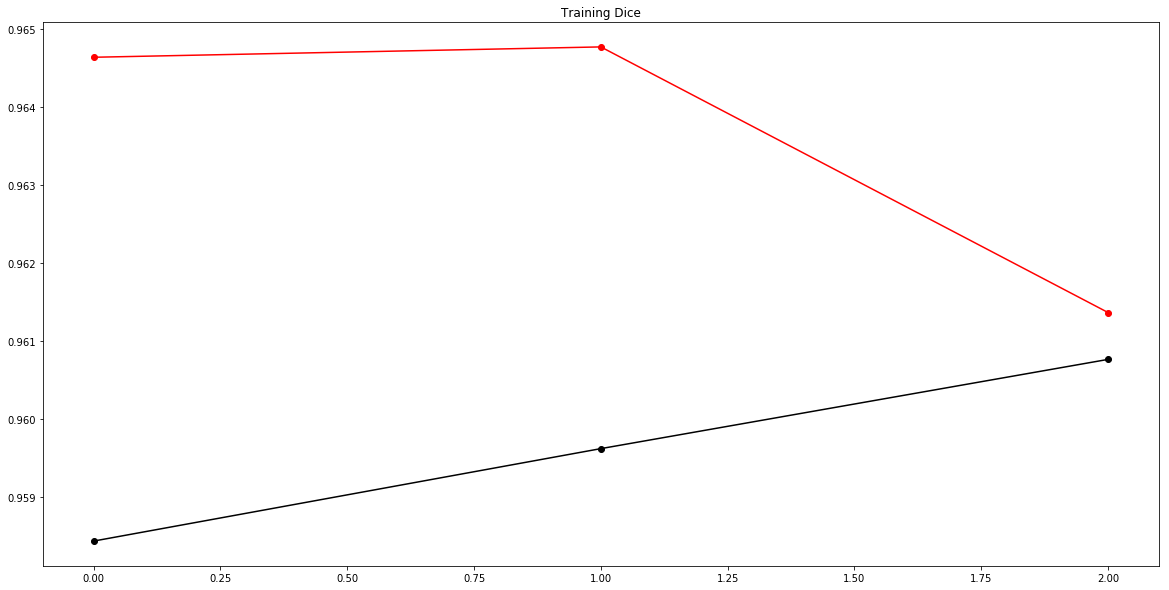

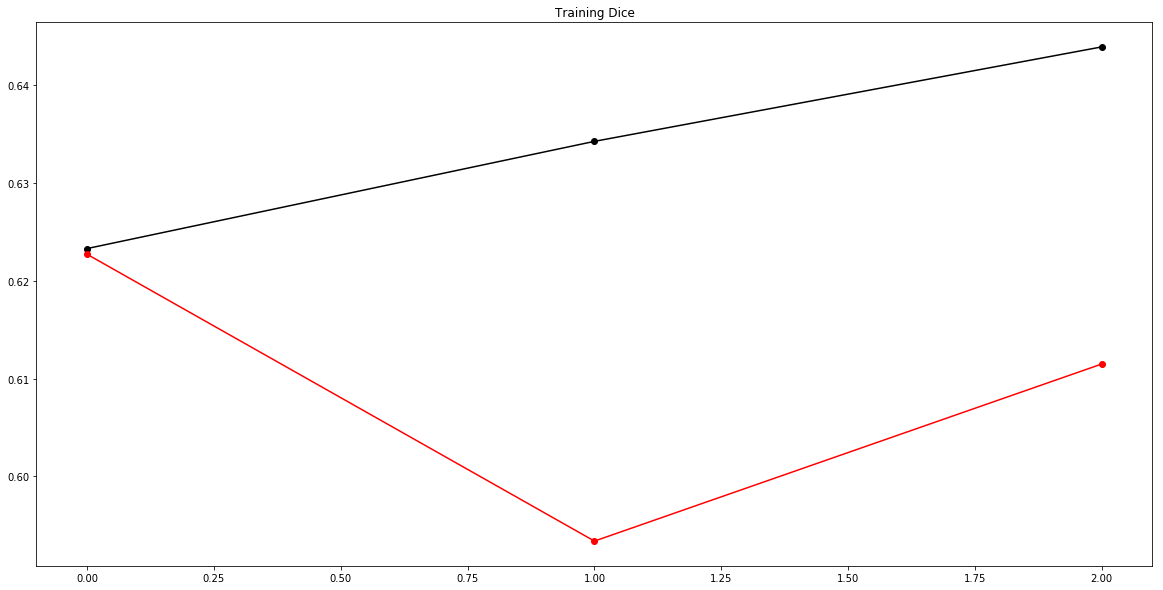

In [62]:
plot_training_best(history_best_unsharp_rep2)

#### With Image augumentation

In [18]:
from skimage.filters import unsharp_mask

# Data generator with preprocessing
class ImgDataGenerator_V2(keras.utils.Sequence):
    
    def __init__(self, df, img_path, outcome_img_shape, batch_size = 1, n_channels=1, 
                 img_normalize=False, img_center = False, img_standardize = False, 
                 shear_range=0.0, zoom_range=0.0,
                 rotation_range=0, brightness_range=None, width_shift_range=0.0, height_shift_range=0.0, 
                 horizontal_flip=False, vertical_flip=False, 
                 use_unsharp_mask=False, unsharp_radius=1.0, unsharp_amount=1.0,
                 shuffle=False):
        super().__init__()
        self.df = df
        self.img_path = img_path
        self.outcome_img_shape = outcome_img_shape
        self.batch_size = batch_size
        self.n_channels = n_channels
        self.img_normalize = img_normalize
        self.img_center = img_center
        self.img_standardize = img_standardize
        self.use_unsharp_mask = use_unsharp_mask
        self.unsharp_radius = unsharp_radius
        self.unsharp_amount = unsharp_amount
        self.shuffle = shuffle
        self.datagen_img = ImageDataGenerator(samplewise_center=img_center, samplewise_std_normalization=img_standardize, 
                                          rescale=1./255 if img_normalize else 1,
                                          shear_range=shear_range, zoom_range=zoom_range,
                                          rotation_range=rotation_range, brightness_range=brightness_range,
                                          width_shift_range=width_shift_range, height_shift_range=height_shift_range,
                                          horizontal_flip=horizontal_flip, vertical_flip=vertical_flip,
                                          fill_mode = "constant", cval=0, data_format='channels_last', dtype='float32')

        self.datagen_mask = ImageDataGenerator(rescale=1./255 if img_normalize else 1,
                                          shear_range=shear_range, zoom_range=zoom_range,
                                          rotation_range=rotation_range, brightness_range=brightness_range,
                                          width_shift_range=width_shift_range, height_shift_range=height_shift_range,
                                          horizontal_flip=horizontal_flip, vertical_flip=vertical_flip,
                                          fill_mode = "constant", cval=0, data_format='channels_last', dtype='bool')

        self.on_epoch_end()
    
    
    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))
    
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.df))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
        
    
    def __getitem__(self, index): 
        X = np.empty((self.batch_size, *self.outcome_img_shape, self.n_channels), dtype=np.float32)
        y = np.empty((self.batch_size, *self.outcome_img_shape, 1), dtype=np.bool)
        
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        
        for idx, filename in enumerate(self.df['ImageId'].iloc[indexes]):
            #print(filename)
            img = cv2.imread(self.img_path + filename, cv2.IMREAD_UNCHANGED)
            orig_img_shape = img.shape[0:2]
            if self.use_unsharp_mask:
                img = unsharp_mask(img, radius=self.unsharp_radius, amount=self.unsharp_amount)
            if orig_img_shape != self.outcome_img_shape:
                img = cv2.resize(img, tuple(reversed(self.outcome_img_shape)), interpolation=cv2.INTER_AREA)
            X[idx,] = img

            mask = rle2mask(self.df['EncodedPixels'].iloc[indexes[idx]], *orig_img_shape)            
            if orig_img_shape != self.outcome_img_shape:
                mask = cv2.resize(mask, tuple(reversed(self.outcome_img_shape)), interpolation=cv2.INTER_AREA)
            y[idx,:,:,0] = mask
         
        seed = 7
        image_generator = self.datagen_img.flow(X, seed=seed, batch_size=self.batch_size, shuffle=False)
        mask_generator = self.datagen_mask.flow(y, seed=seed, batch_size=self.batch_size, shuffle=False)
        return zip(image_generator, mask_generator).__next__()
        

In [21]:
idx = int(0.8*len(df_train))

dataGen_train_V2 = ImgDataGenerator_V2(df_train.iloc[:idx], './input/severstal-steel-defect-detection/train_images/', 
                                    outcome_img_shape=(128, 800), batch_size = 8, n_channels=3, 
                                    img_normalize=False, img_center=False, img_standardize=False,
                                    use_unsharp_mask=True, unsharp_radius=4, unsharp_amount=1.5,
                                    shear_range=1, #OK
                                    zoom_range=[0.95,1.05], # OK
                                    #brightness_range=[0.9,1.1],
                                    rotation_range=1, #OK
                                    width_shift_range=0.015, height_shift_range=0.05,#OK
                                    horizontal_flip=True, vertical_flip=True, #OK
                                    shuffle=False)

dataGen_valid_V2 = ImgDataGenerator_V2(df_train.iloc[idx:], './input/severstal-steel-defect-detection/train_images/', 
                                    outcome_img_shape=(128, 800), batch_size = 8, n_channels=3, 
                                    img_normalize=False, img_center=False, img_standardize=False,
                                    use_unsharp_mask=True, unsharp_radius=4, unsharp_amount=1.5,
                                    shear_range=1, #OK
                                    zoom_range=[0.95,1.05], # OK
                                    #brightness_range=[0.9,1.1],
                                    rotation_range=1, #OK
                                    width_shift_range=0.015, height_shift_range=0.05,#OK
                                    horizontal_flip=True, vertical_flip=True, #OK
                                    shuffle=False)

history_best_unsharp = advanced_model.fit_generator(dataGen_train_V2, 
                                                    epochs=5,    
                                                    validation_data=dataGen_valid_V2,
                                                    verbose=1,
                                                    shuffle=False,
                                                    callbacks = get_callback(2)
                                                   )

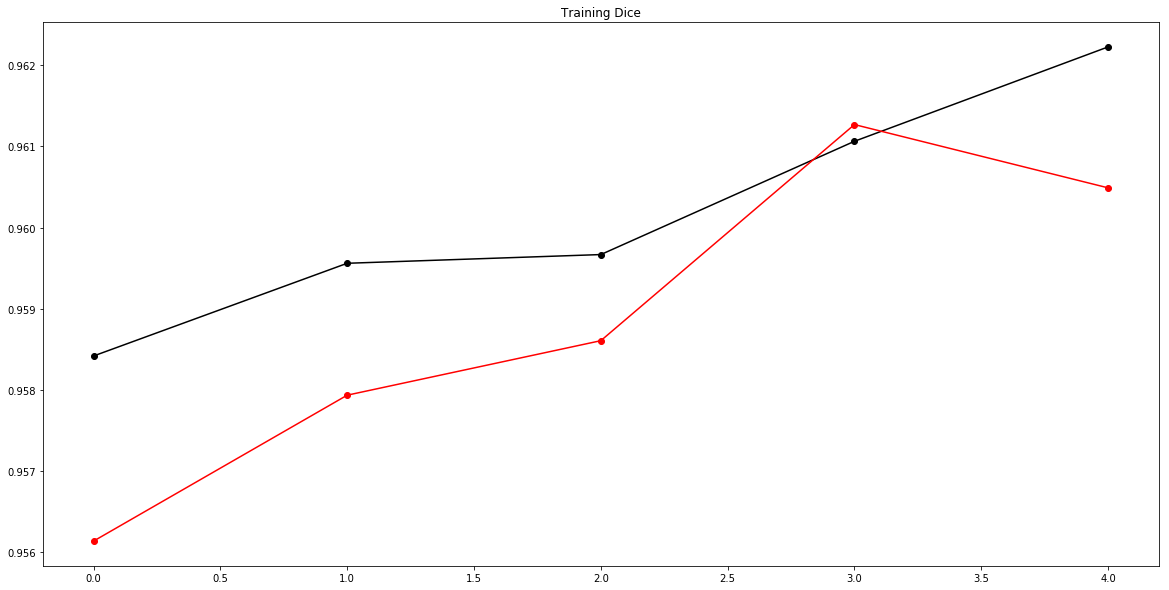

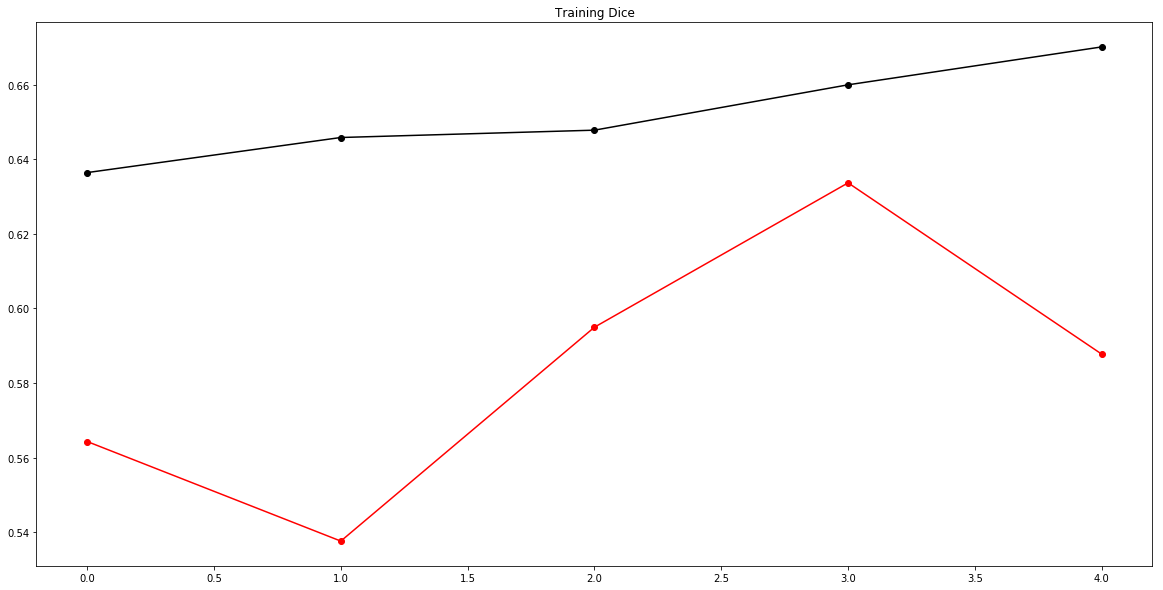

In [84]:
plot_training_best(history_best_unsharp)

#### Load model (if needed)

In [32]:
from keras.models import load_model

#model = load_model('Xcep_model_CD_LR0_01.h5')
model = load_model('Xcep_model_CD_LR0_01.h5', custom_objects={
    'bce_dice_loss': bce_dice_loss,
    'dice_coeff': dice_coeff}
                  )

Instructions for updating:
Use tf.cast instead.


In [35]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 128, 800, 3)  0                                            
__________________________________________________________________________________________________
conv2d_169 (Conv2D)             (None, 128, 800, 32) 896         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_163 (BatchN (None, 128, 800, 32) 128         conv2d_169[0][0]                 
__________________________________________________________________________________________________
activation_163 (Activation)     (None, 128, 800, 32) 0           batch_normalization_163[0][0]    
__________________________________________________________________________________________________
conv2d_170

__________________________________________________________________________________________________
batch_normalization_174 (BatchN (None, 4, 50, 1024)  4096        conv2d_180[0][0]                 
__________________________________________________________________________________________________
activation_174 (Activation)     (None, 4, 50, 1024)  0           batch_normalization_174[0][0]    
__________________________________________________________________________________________________
up_sampling2d_31 (UpSampling2D) (None, 8, 50, 1024)  0           activation_174[0][0]             
__________________________________________________________________________________________________
concatenate_31 (Concatenate)    (None, 8, 50, 1536)  0           activation_172[0][0]             
                                                                 up_sampling2d_31[0][0]           
__________________________________________________________________________________________________
conv2d_181

__________________________________________________________________________________________________
activation_184 (Activation)     (None, 64, 400, 64)  0           batch_normalization_184[0][0]    
__________________________________________________________________________________________________
conv2d_191 (Conv2D)             (None, 64, 400, 64)  36928       activation_184[0][0]             
__________________________________________________________________________________________________
batch_normalization_185 (BatchN (None, 64, 400, 64)  256         conv2d_191[0][0]                 
__________________________________________________________________________________________________
activation_185 (Activation)     (None, 64, 400, 64)  0           batch_normalization_185[0][0]    
__________________________________________________________________________________________________
conv2d_192 (Conv2D)             (None, 64, 400, 64)  36928       activation_185[0][0]             
__________

#### Predictions

In [50]:
dataGen_valid_V2 = ImgDataGenerator_V2(df_train.iloc[idx: idx+12], './input/severstal-steel-defect-detection/train_images/', 
                                    outcome_img_shape=(128, 800), batch_size = 12, n_channels=3, 
                                    img_normalize=False, img_center=False, img_standardize=False,
                                    use_unsharp_mask=True, unsharp_radius=4, unsharp_amount=1.5,
                                    shear_range=1, #OK
                                    zoom_range=[0.95,1.05], # OK
                                    rotation_range=1, #OK
                                    width_shift_range=0.015, height_shift_range=0.05,#OK
                                    horizontal_flip=True, vertical_flip=True, #OK
                                    shuffle=False)

print('Running predictions')
preds = model.predict_generator(dataGen_valid_V2,verbose=1)

print(preds.shape)

Running predictions
1/1 [==============================] - 3s 3s/step
(12, 128, 800, 1)


In [65]:
def mask2pad(mask, pad=2):
    # ENLARGE MASK TO INCLUDE MORE SPACE AROUND DEFECT
    w = mask.shape[1]
    h = mask.shape[0]
    
    # MASK UP
    for k in range(1,pad,2):
        temp = np.concatenate([mask[k:,:],np.zeros((k,w))],axis=0)
        mask = np.logical_or(mask,temp)
    # MASK DOWN
    for k in range(1,pad,2):
        temp = np.concatenate([np.zeros((k,w)),mask[:-k,:]],axis=0)
        mask = np.logical_or(mask,temp)
    # MASK LEFT
    for k in range(1,pad,2):
        temp = np.concatenate([mask[:,k:],np.zeros((h,k))],axis=1)
        mask = np.logical_or(mask,temp)
    # MASK RIGHT
    for k in range(1,pad,2):
        temp = np.concatenate([np.zeros((h,k)),mask[:,:-k]],axis=1)
        mask = np.logical_or(mask,temp)
    
    return mask 


def mask2contour(mask, width=3):
    # CONVERT MASK TO ITS CONTOUR
    w = mask.shape[1]
    h = mask.shape[0]
    mask2 = np.concatenate([mask[:,width:],np.zeros((h,width))],axis=1)
    mask2 = np.logical_xor(mask,mask2)
    mask3 = np.concatenate([mask[width:,:],np.zeros((width,w))],axis=0)
    mask3 = np.logical_xor(mask,mask3)
    return np.logical_or(mask2,mask3) 

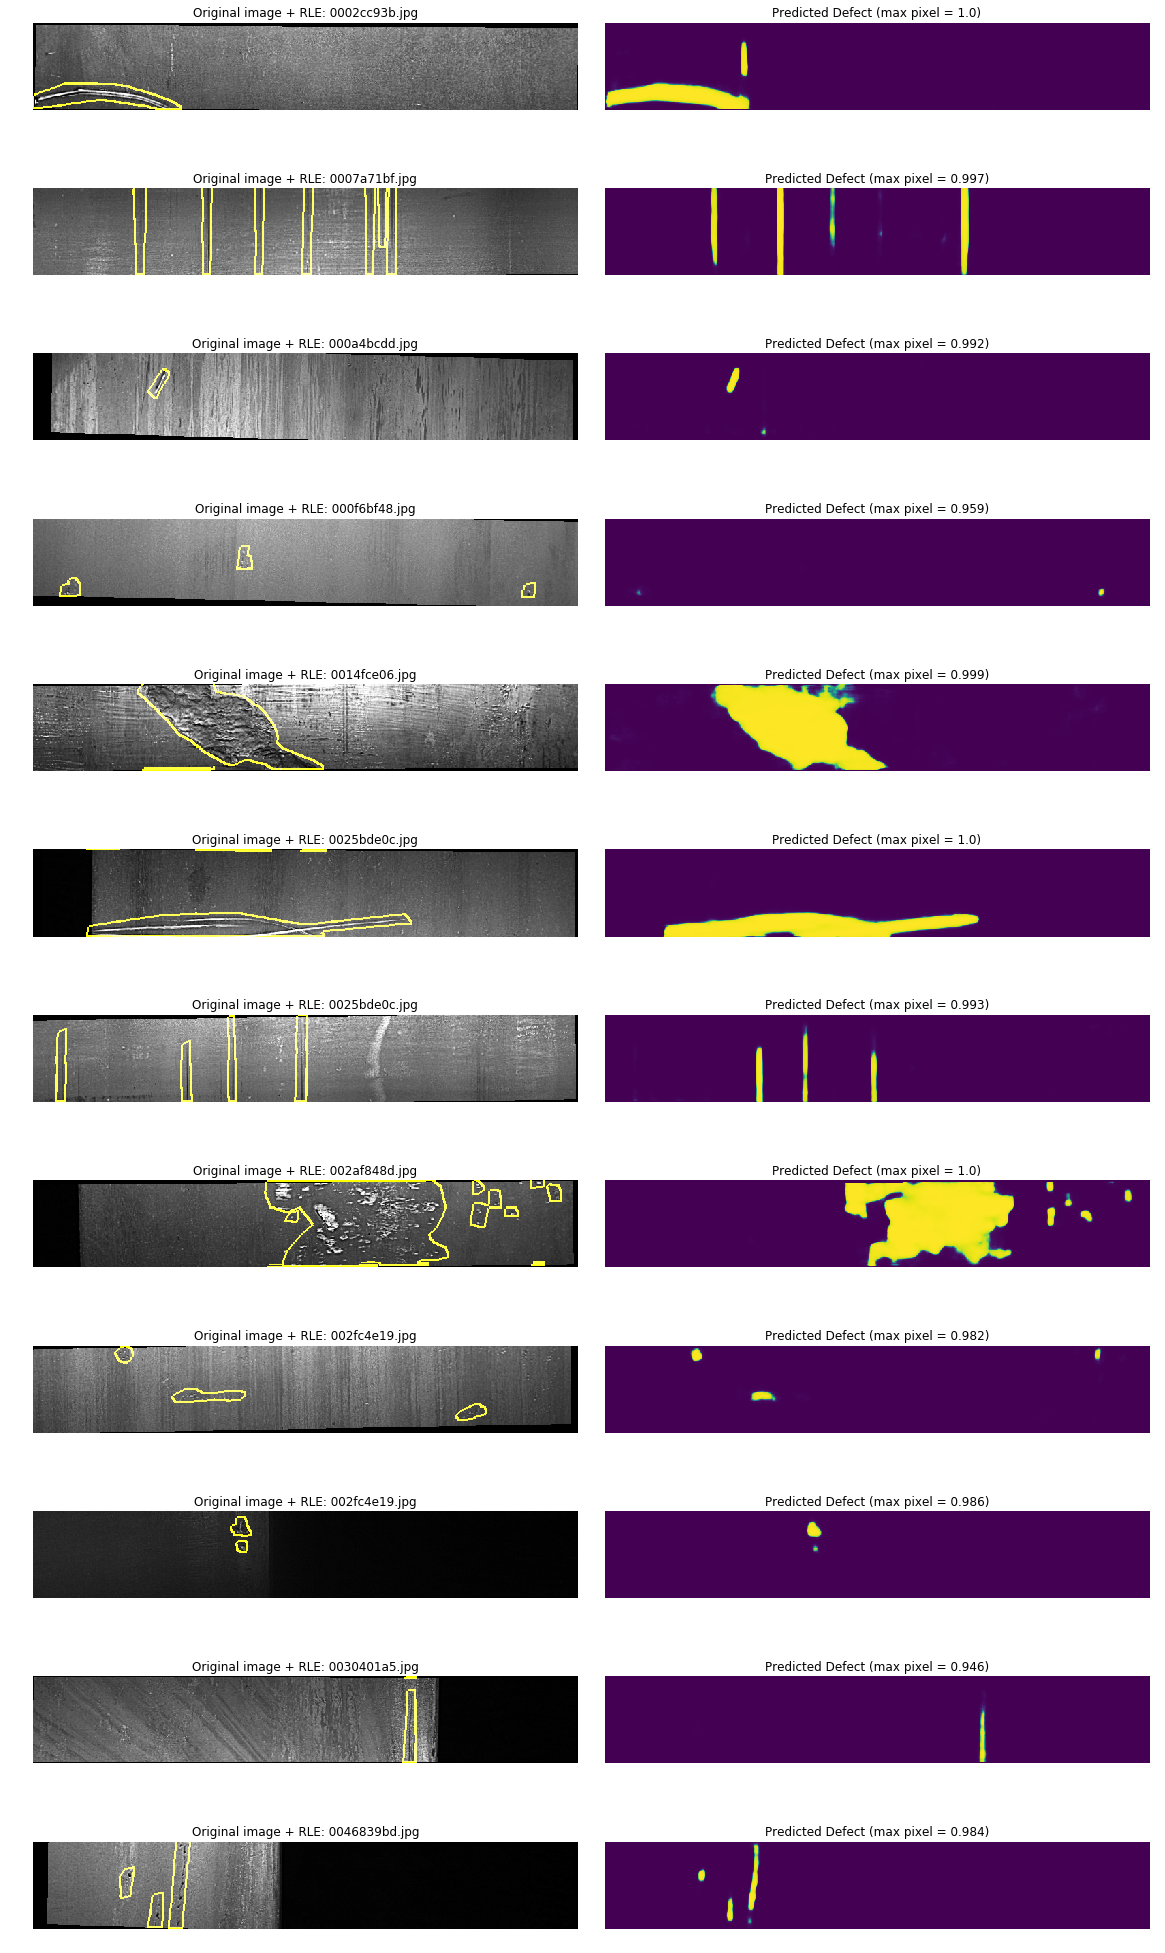

In [76]:
for i,batch in enumerate(dataGen_valid_V2):
    plt.figure(figsize=(20,36))
    for k in range(12):
        plt.subplot(12,2,2*k+1)
        img = batch[0][k,]
        img *=255
        img = Image.fromarray(img.astype('uint8'))
        img = np.array(img)
        
        msk = batch[1][k,:,:,0]
        msk = mask2pad(msk,pad=2)
        msk = mask2contour(msk,width=3)
        img[msk==1,0] = 255 
        img[msk==1,1] = 255
                
        plt.title('Original image + RLE: '+df_train.iloc[12*i+k,0])
        plt.axis('off') 
        plt.imshow(img)
        plt.subplot(12,2,2*k+2) 
        preds_msk = preds[12*i+k,:,:,0]
        plt.imshow(preds_msk)
        plt.axis('off')
        mx = np.round(np.max(preds_msk),3)
        plt.title('Predicted Defect (max pixel = '+str(mx)+')')
    plt.subplots_adjust(wspace=0.05)
    plt.show()